<a href="https://colab.research.google.com/github/jryzj/stock_predict/blob/master/stock_preditct_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Begin

##mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdriver')

Mounted at /content/gdriver


In [ ]:
!nvidia-smi

Sat Oct  3 07:41:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
TCMALLOC_LARGE_ALLOC_REPORT_THRESHOLD

NameError: ignored

In [ ]:
#for tensorflow2

import sys
sys.path
# sys.path[0]='/tensorflow-2.1.0/python3.6'
sys.path[0]='/usr/local/lib/python3.6'
sys.path

['/usr/local/lib/python3.6',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
import tensorflow as tf
tf.__version__

# tf.compat.v1.disable_eager_execution()


'2.3.0'

In [ ]:
%tensorflow_version 2.x

In [ ]:
!ls -l /

total 104
drwxr-xr-x   1 root root 4096 Sep 28 16:28 bin
drwxr-xr-x   2 root root 4096 Apr 24  2018 boot
drwxr-xr-x   1 root root 4096 Oct  1 06:34 content
drwxr-xr-x   1 root root 4096 Sep 29 16:40 datalab
drwxr-xr-x   5 root root  440 Oct  1 06:27 dev
drwxr-xr-x   1 root root 4096 Oct  1 06:27 etc
drwxr-xr-x   2 root root 4096 Apr 24  2018 home
drwxr-xr-x   1 root root 4096 Sep 28 16:30 lib
drwxr-xr-x   2 root root 4096 Sep 28 16:23 lib32
drwxr-xr-x   2 root root 4096 Aug  7 22:41 lib64
drwxr-xr-x   2 root root 4096 Aug  7 22:39 media
drwxr-xr-x   2 root root 4096 Aug  7 22:39 mnt
drwxr-xr-x   1 root root 4096 Oct  1 06:27 opt
dr-xr-xr-x 141 root root    0 Oct  1 06:27 proc
drwx------   1 root root 4096 Oct  1 07:10 root
drwxr-xr-x   1 root root 4096 Sep 28 16:25 run
drwxr-xr-x   1 root root 4096 Sep 28 16:28 sbin
drwxr-xr-x   2 root root 4096 Aug  7 22:39 srv
drwxr-xr-x   4 root root 4096 Sep 29 16:40 swift
dr-xr-xr-x  12 root root    0 Oct  1 06:40 sys
drwxr-xr-x   4 root root 4096

In [ ]:
# !pip install tensorflow==2.3.1
# !pip install tf-nightly
!pip install tf-nightly-gpu


     |████████████████████████████████| 391.8MB 36kB/s 
     |████████████████████████████████| 10.6MB 62.4MB/s 
     |████████████████████████████████| 471kB 56.9MB/s 


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

#change path to notebook in cloud

In [ ]:
import os
os.getcwd()
# os.chdir("/../content/gdriver/My Drive/Colab Notebooks (1)")
os.chdir("/../content/gdriver/My Drive/Colab Notebooks")

# os.chdir("/../content/gdriver/My Drive")
# os.chdir("gdriver/My Drive/Colab Notebooks")

In [ ]:
!ls

#set constants

In [ ]:
#常数设置

threshold = 3.0 #涨幅
start_date = "2006-01-01"
end_date = "2019-06-23"
stock_prefix = "sh.6|sz.0|sz.300"

window_size = 90
predict_window_size = 5
# adjustflag = "1" #后复权
adjustflag = "3" #不复权
days_from_ipo = 40 #新股上市一般会连涨很多天，排除这些比较异常的天数

data_fields = ["open", "high", "low", "close", "turn","pctChg","tradestatus","isST","code"]
all_data_fields = "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST"
data_fields_market_index = ["open", "high", "low", "close", "turn","pctChg","date"]


# factor_num = len(data_fields) - 4 #pctChg, tradestatus, code isST不参与模型计算
factor_num = 12

all_stock_data = "all_stock_data.csv"
all_stock_data_1 = "all_stock_data_1.csv"
all_stock_data_2 = "all_stock_data_2.csv" #不复权
all_stock_data_3 = "all_stock_data_3.csv" #with all data fields, no divid adjusting

ts_code_file = "ts_code.csv"
market_index = ["sh.000001", "sz.399106"]
market_index_data_file = "market_index_data.csv"

# predict_next_days = 1
predict_next_days = 20

#intall pack necessary

In [ ]:
!pip install baostock
import baostock as bs

     |████████████████████████████████| 61kB 2.0MB/s 


#import basic pack

In [ ]:
#引入基本包

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import baostock as bs
import random
import datetime

import gc

import tracemalloc


np.random.seed(2019)

!pip install gputil

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

def show_mem(gpu = False):
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 if gpu:
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
show_mem(gpu)

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=98209c959f665719eda6665f734b82bc6cdc343789814ca96df123f585b56a6b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 112.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


#import keras pack

In [ ]:
##for tensorflow2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import utils
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LambdaCallback

class Running(Callback):
  def on_train_begin(self, sign_gen):
    next(sign_gen)


In [ ]:
!pip install --upgrade keras

     |████████████████████████████████| 378kB 27.2MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
print(keras.__version__)

2.4.0


#setup tensorboard if need

In [ ]:
LOG_DIR = "/content/gdriver/My\ Drive/Colab\ Notebooks/tensor_board/stock_predict_2"
LOG_DIR1 = "/content/gdriver/My Drive/Colab Notebooks/tensor_board/stock_predict_2"

from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir= LOG_DIR1 , histogram_freq=1,
#                          write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
#                          write_images=True
                        )

#setup ngrok if need

##install ngrok

In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

##setup ngrok account

In [ ]:
!./ngrok authtoken 6wz1ai2QDnxrk1HYUor4U_4zjD6PD8wUkGyMnWnmXiQ
# get_ipython().system_raw('./ngrok authtoken 6wz1ai2QDnxrk1HYUor4U_4zjD6PD8wUkGyMnWnmXiQ')

##start ngrok service

In [ ]:
#开启ngrok service，绑定port 6006(tensorboard)
get_ipython().system_raw('./ngrok http 6006 &')
# !./ngrok http 6006

##get ngrok website

In [ ]:
! curl http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

#get ts code

In [ ]:
#获取股票代码清单
#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### 获取证券信息 ####
rs = bs.query_all_stock(day="2019-06-28")
print('query_all_stock respond error_code:'+rs.error_code)
print('query_all_stock respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
ts_code = pd.DataFrame(data_list, columns=rs.fields)

#### 结果集输出到csv文件 ####   
# ts_code.to_csv("D:\\all_stock.csv", encoding="gbk", index=False)
print(ts_code)

#### 登出系统 ####
bs.logout()

#get ts histroy data

In [ ]:
#获取股票历史数据
#用DataFrame.append的方法是需要重新分配内存，完成追加数据
#先用list.append的方法是用指针指向追加数据，内存不重新分配，数据大的时候，效率高
#每次获取一支股票的数据，追加到csv文件中。
#不复权

adjustflag = "3"  #不复权

result = pd.DataFrame([],columns = all_data_fields.split(","))
result.to_csv(all_stock_data_3)

bs.login()
for i in range(len(ts_code)):
    if i % 50 == 0:
        print(i)
    rs = bs.query_history_k_data_plus(ts_code.iloc[i]["code"], all_data_fields,\
                start_date = start_date, end_date = end_date,\
                  frequency = "d", adjustflag = adjustflag) #不复权

    data_list = []
    while (rs.error_code == "0") and rs.next():
        row_data = rs.get_row_data()
        # if(row_data[6] == "1"):    #  停牌的日子还是应该获取的。   
        data_list.append(row_data)
    result = pd.DataFrame(data_list, columns = rs.fields)
    result.to_csv(all_stock_data_3, mode = "a", header=False)

bs.logout()


print(result.head())
print(result.tail())
print(result.shape[0])

login success!
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
logout success!
         date       code     open  ... tradestatus     pctChg isST
0  2019-06-18  sz.300782  42.3500  ...           1  44.006800    0
1  2019-06-19  sz.300782  55.9000  ...           1   9.996069    0
2  2019-06-20  sz.300782  61.4900  ...           1  10.000000    0
3  2019-06-21  sz.300782  67.6400  ...           1  10.001620    0

[4 rows x 14 columns]
         date       code     open  ... tradestatus     pctChg isST
0  2019-06-18  sz.300782  42.3500  ...           1  44.006800    0
1  2019-06-19  sz.300782  55.9000  ...           1   9.996069    0
2  2019-06-20  sz.300782  61.4900  ...           1  10.000000    0
3

In [ ]:
#

adjustflag = "3"  #不复权

result = pd.DataFrame([],columns = all_data_fields.split(","))
result.to_csv(market_index_data)

bs.login()
for i in range(len(market_index)):
  print(market_index[i])
  rs = bs.query_history_k_data_plus(market_index[i], all_data_fields,\
                start_date = start_date, end_date = end_date,\
                  frequency = "d", adjustflag = adjustflag) #不复权

  data_list = []
  while (rs.error_code == "0") and rs.next():
      row_data = rs.get_row_data() 
      data_list.append(row_data)
  result = pd.DataFrame(data_list, columns = rs.fields)
  result.to_csv(market_index_data, mode = "a", header=False)

bs.logout()


print(result.head())
print(result.tail())
print(result.shape[0])

login success!
sh.000001
sz.399106
logout success!
         date       code      open  ... tradestatus    pctChg isST
0  2006-01-04  sz.399106  278.9900  ...           1  1.696865    0
1  2006-01-05  sz.399106  283.8000  ...           1  1.993084    0
2  2006-01-06  sz.399106  289.5700  ...           1  0.747070    0
3  2006-01-09  sz.399106  291.4800  ...           1  1.023029    0
4  2006-01-10  sz.399106  294.1500  ...           1  0.584498    0

[5 rows x 14 columns]
            date       code       open  ... tradestatus     pctChg isST
3268  2019-06-17  sz.399106  1504.2410  ...           1  -0.195000    0
3269  2019-06-18  sz.399106  1502.9070  ...           1   0.162700    0
3270  2019-06-19  sz.399106  1542.4600  ...           1   1.475500    0
3271  2019-06-20  sz.399106  1525.5030  ...           1   1.953800    0
3272  2019-06-21  sz.399106  1567.0710  ...           1   1.339000    0

[5 rows x 14 columns]
3273


#load stock data

In [ ]:
ts_data = pd.read_csv(all_stock_data_3)
print(ts_data.head())
# print(ts_data.tail())

ts_code = pd.read_csv(ts_code_file)
# print(ts_code.head())

market_index_data = pd.read_csv(market_index_data_file)
print(market_index_data.head())
# print(market_index_data.tail())

market_index_data_sh = market_index_data[market_index_data["code"] == market_index[0]]
market_index_data_sh = market_index_data_sh[data_fields_market_index]
print(market_index_data_sh.head())
print(market_index_data_sh.tail())
market_index_data_sz = market_index_data[market_index_data["code"] == market_index[1]].reset_index()
market_index_data_sz = market_index_data_sz[data_fields_market_index]
print(market_index_data_sz.head())
print(market_index_data_sz.tail())
market_index_data = (market_index_data_sh.values,\
                     market_index_data_sz.values)


   Unnamed: 0        date       code  ...  tradestatus    pctChg  isST
0           0  2006-01-04  sh.600000  ...            1  5.128205     0
1           1  2006-01-05  sh.600000  ...            1  1.658537     0
2           2  2006-01-06  sh.600000  ...            1  2.879081     0
3           3  2006-01-09  sh.600000  ...            1 -1.212688     0
4           4  2006-01-10  sh.600000  ...            1  0.283284     0

[5 rows x 15 columns]
   Unnamed: 0        date       code  ...  tradestatus    pctChg  isST
0           0  2006-01-04  sh.000001  ...            1  1.714473   0.0
1           1  2006-01-05  sh.000001  ...            1  1.380740   0.0
2           2  2006-01-06  sh.000001  ...            1  1.015056   0.0
3           3  2006-01-09  sh.000001  ...            1  0.516443   0.0
4           4  2006-01-10  sh.000001  ...            1  0.407190   0.0

[5 rows x 15 columns]
       open      high       low     close      turn    pctChg        date
0  1163.878  1181.004  1161.

In [ ]:
type(ts_data.date[0])

str

In [ ]:
market_index_data[0]

array([[0, '2006-01-04', 'sh.000001', ..., 1, 1.714473, 0.0],
       [1, '2006-01-05', 'sh.000001', ..., 1, 1.3807399999999999, 0.0],
       [2, '2006-01-06', 'sh.000001', ..., 1, 1.015056, 0.0],
       ...,
       [3270, '2019-06-19', 'sh.000001', ..., 1, 0.9565, 0.0],
       [3271, '2019-06-20', 'sh.000001', ..., 1, 2.3756, 0.0],
       [3272, '2019-06-21', 'sh.000001', ..., 1, 0.4975, 0.0]],
      dtype=object)

In [ ]:
ts_code = pd.read_csv(ts_code_file)
print(ts_code.head())

   Unnamed: 0       code code_name
0           0  sh.600000      浦发银行
1           1  sh.600004      白云机场
2           2  sh.600006      东风汽车
3           3  sh.600007      中国国贸
4           4  sh.600008      首创股份


#prepare dataset

##define dataset generating function

In [ ]:
def normals(np_array):
  max_price = np_array.max()
  min_price = np_array.min()
  scale = max_price - min_price
  return (np_array - min_price)/scale

In [ ]:


def gntor_like(ts_data, ts_code, mark_index_data, pct_of_stock=0.05, edge=10.0,\
                    shuffle = 0, y_cate = 1):  

  stock_qty = len(ts_code)

  
  if pct_of_stock != 1:
    index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))
    ts_code = ts_code[ts_code.index.isin(index)].code.values
  else:
    index = ts_code.code.values
  
  print(len(index))                   

  x = []
  y = []

  for i in index:

    stk_data = ts_data[ts_data["code"] == i]
    length = len(stk_data)
    if ((length - days_from_ipo - predict_next_days) > window_size):
      for l in range(days_from_ipo, length - window_size - predict_next_days):
        ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
            [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values.astype("float")
        if np.all(ohlct[:,5] != 1) and \
          np.all(ohlct[:,4] != 0) and \
        np.all(ohlct[:,6] >= -10.1) and \
        np.all(ohlct[:,6] <= 10.1) :
          ohlct[:-predict_next_days,:4] = normals(ohlct[:-predict_next_days,:4])

          date_range = stk_data.iloc[l : l + window_size + predict_next_days]["date"]

          sh_index_data = market_index_data[(market_index_data["code"] == market_index[0])\
           & (market_index_data["date"].isin(date_range))]
          sh_index_data = sh_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
          sh_index_data = normals(sh_index_data)


          sz_index_data = market_index_data[(market_index_data["code"] == market_index[1])\
           & (market_index_data["date"].isin(date_range))]
          sz_index_data = sz_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
          sz_index_data = normals(sz_index_data) 

          x.append(np.expand_dims(np.hstack((ohlct[:-predict_next_days,:4], sh_index_data, sz_index_data)), axis=-1))

          # next_days_pctChg = ohlct[-predict_next_days:,-1].sum()  #wrong
          next_days_pctChg = (ohlct[-1,3] - ohlct[-predict_next_days,3]) * 100 / ohlct[-predict_next_days,3]

          if next_days_pctChg  <= -edge:
            y.append(0)
          elif next_days_pctChg  <= 0:
            y.append(1)
          elif next_days_pctChg <= edge:
            y.append(2)
          else:
            y.append(3)

  if len(x) > 0:
    X = np.array(x)
    y = np.array(y)

    # upsample
    # dis = district

    dis_count, dis_edge = np.histogram(y, bins = 4, range=(0,3))

    dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
    dis_count_max = dis_count.max()

    time = dis_count_max/dis_count

    # time = time.astype(int)

    # time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
    #                                 0 , y)

    # X = np.repeat(X, time_count, axis = 0)
    # y = np.repeat(y, time_count, axis = 0)

    # shuffle dataset
    if shuffle:
      length = X.shape[0]

      r_index = np.arange(length)
      np.random.shuffle(r_index)

      X = X[r_index]
      y = y[r_index]

    # r_index = random.sample(range(0,length), int(length / 4))

    # X = X[r_index]
    # y = y[r_index]

    if y_cate:
      y = utils.to_categorical(y, num_classes=4)
    return X, y, time


##make dataset

In [ ]:
pct_of_stock = 1
edge = 10.0

X1, y1, cls_weight = gntor(result, ts_code[:10], market_index_data, pct_of_stock, edge, [], 1, 0)

np.save("X-3-1-7-w1000.npy", X1)
np.save("y-3-1-7-w1000.npy", y1)

10


##generator

###G1

In [ ]:
def G1(ts_data, ts_code, mark_index_data, pct_of_stock=0.05, edge=10.0,\
        shuffle = 0, y_cate = 1, batch_size=256, generator = 1, repeat_time = 10):  

  stock_qty = len(ts_code)

  while True:
    if pct_of_stock != 1:
      index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))
      index = ts_code[ts_code.index.isin(index)].code.values
    else:
      index = ts_code.code.values
    
    print(len(index))                   

    x = []
    y = []

    for i in index:
      stk_data = ts_data[ts_data["code"] == i]
      length = len(stk_data)
      if ((length - days_from_ipo - predict_next_days) > window_size):
        # print("0:", datetime.datetime.today())
        for l in range(days_from_ipo, length - window_size - predict_next_days):
          # print("1:", datetime.datetime.today())
          ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
              [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values.astype("float")
          if np.all(ohlct[:,5] != 1) and \
            np.all(ohlct[:,4] != 0) and \
          np.all(ohlct[:,6] >= -10.1) and \
          np.all(ohlct[:,6] <= 10.1) :
            # print("2:", datetime.datetime.today())
            ohlct[:-predict_next_days,:4] = normals(ohlct[:-predict_next_days,:4])

            date_range = stk_data.iloc[l : l + window_size + predict_next_days]["date"]
            # print(date_range.iloc[0])
            # print(type(date_range))

            # print("2.1:", datetime.datetime.today())
            index_begin = market_index_data[0][market_index_data[0]["date"] == date_range.iloc[0]].index.tolist()[0]
            # print("2.2:", datetime.datetime.today())
            sh_index_data = market_index_data[0][index_begin: index_begin + window_size]
            # print("2.3:", datetime.datetime.today())
            sh_index_data = sh_index_data[["open", "high", "low", "close"]].values.astype("float")
            # print("2.4:", datetime.datetime.today())
            sh_index_data = normals(sh_index_data)
            # print("2.5:", datetime.datetime.today())

            index_begin = market_index_data[1][market_index_data[1]["date"] == date_range.iloc[0]].index.tolist()[0]
            sz_index_data = market_index_data[1][index_begin: index_begin + window_size]
            sz_index_data = sz_index_data[["open", "high", "low", "close"]].values.astype("float")
            sz_index_data = normals(sz_index_data)





            # date_range = stk_data.iloc[l : l + window_size + predict_next_days]["date"]

            # sh_index_data = market_index_data[0][market_index_data[0]["date"].isin(date_range)]
            # sh_index_data = sh_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
            # sh_index_data = normals(sh_index_data)


            # sz_index_data = market_index_data[1][market_index_data[1]["date"].isin(date_range)]
            # sz_index_data = sz_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
            # sz_index_data = normals(sz_index_data) 

            # print("3:", datetime.datetime.today())
            x.append(np.expand_dims(np.hstack((ohlct[:-predict_next_days,:4], sh_index_data, sz_index_data)), axis=-1))

            # print("4:", datetime.datetime.today())
            next_days_pctChg = (ohlct[-1,3] - ohlct[-predict_next_days,3]) * 100 / ohlct[-predict_next_days,3]

            if next_days_pctChg  <= -edge:
              y.append(0)
            elif next_days_pctChg  <= 0:
              y.append(1)
            elif next_days_pctChg <= edge:
              y.append(2)
            else:
              y.append(3)

    if len(x) > 0:
      print(len(x), datetime.datetime.today())
      X = np.array(x)
      y = np.array(y)

      # upsample
      # dis = district

      dis_count, dis_edge = np.histogram(y, bins = 4, range=(0,3))

      dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
      dis_count_min = dis_count.min()
      print(dis_count_min)

      time = dis_count_min/dis_count
      print(time)

      sample_weight = np.array(y).astype("float")
      sample_weight[sample_weight == 0] = time[0]
      sample_weight[sample_weight == 1] = time[1]
      sample_weight[sample_weight == 2] = time[2]
      sample_weight[sample_weight == 3] = time[3]


      # time = time.astype(int)

      # time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
      #                                 0 , y)

      # X = np.repeat(X, time_count, axis = 0)
      # y = np.repeat(y, time_count, axis = 0)

      # shuffle dataset
      if shuffle:
        length = X.shape[0]

        r_index = np.arange(length)
        np.random.shuffle(r_index)

        X = X[r_index]
        y = y[r_index]

      # r_index = random.sample(range(0,length), int(length / 4))

      # X = X[r_index]
      # y = y[r_index]

      if y_cate:
        y = utils.to_categorical(y, num_classes=4)
      
      if generator == 1:
        for ii in range(repeat_time):
          for i in range(0, y.shape[0], batch_size):
            yield (X[i : i + batch_size], y[i : i + batch_size]\
                  , sample_weight[i : i + batch_size]\
                  )
      else:
        print("0")
        return X, y, sample_weight

        
        


###G2

In [ ]:
def for_isin(row, index, collection):
  return row[index] in collection

def G2(ts_data, ts_code, mark_index_data, pct_of_stock=0.05, edge=10.0,\
        shuffle = 0, y_cate = 1, batch_size=256, generator = 1, repeat_time = 10):  

  stock_qty = len(ts_code)

  # x = None
  # y = None
  # X = None
  # sample_weight = None
  # stk_data = None

  while True:    


    x = None
    y = None
    X = None
    sample_weight = None
    stk_data = None
    print("collect",gc.collect())

    show_mem(gpu)

    if pct_of_stock != 1:
      index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))
      index = ts_code[ts_code.index.isin(index)].code.values
    else:
      index = ts_code.code.values
    
    print(len(index))                   

    x = []
    y = []

    for i in index:
      stk_data = ts_data[ts_data["code"] == i]
      stk_data = stk_data[["open", "high", "low", "close", "tradestatus", "isST", "pctChg", "date"]].values
      length = len(stk_data)
      if ((length - days_from_ipo - predict_next_days) > window_size):
        # print("0:", datetime.datetime.today())
        for l in range(days_from_ipo, length - window_size - predict_next_days):
          # print("1:", datetime.datetime.today())
          ohlct = stk_data[l : l + window_size + predict_next_days,:-1].astype("float")
          # print(id(ohlct))
          # print(id(stk_data[l : l + window_size + predict_next_days,:-1]))
          if np.all(ohlct[:,5] != 1) and \
            np.all(ohlct[:,4] != 0) and \
            np.all(ohlct[:,6] >= -10.1) and \
            np.all(ohlct[:,6] <= 10.1) :
            # print("2:", datetime.datetime.today())
            ohlct[:-predict_next_days,:4] = normals(ohlct[:-predict_next_days,:4])
            # print(id(ohlct))
            date_range = stk_data[l, 7]
            # print(date_range.iloc[0])
            # print(type(date_range))

            # print("2.1:", datetime.datetime.today())
            index_begin = np.where(market_index_data[0][:,-1] == date_range)[0][0]
            # print(index_begin)
            # print("2.2:", datetime.datetime.today())
            sh_index_data = market_index_data[0][index_begin: index_begin + window_size, :]
            # sh_index_data = market_index_data[0][np.in1d(market_index_data[0][:,-1],date_range)]
            # sh_index_data = market_index_data[0][np.apply_along_axis(for_isin, 1, market_index_data[0], -1, date_range)]
            # print("2.3:", datetime.datetime.today())
            sh_index_data = sh_index_data[:,:4].astype("float")
            # print("2.4:", datetime.datetime.today())
            sh_index_data = normals(sh_index_data)
            # print("2.5:", datetime.datetime.today())

            sz_index_data = market_index_data[1][index_begin: index_begin + window_size, :]
            # sz_index_data = market_index_data[1][np.in1d(market_index_data[1][:,-1],date_range)]
            sz_index_data = sz_index_data[:,:4].astype("float")
            sz_index_data = normals(sz_index_data)





            # date_range = stk_data.iloc[l : l + window_size + predict_next_days]["date"]

            # sh_index_data = market_index_data[0][market_index_data[0]["date"].isin(date_range)]
            # sh_index_data = sh_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
            # sh_index_data = normals(sh_index_data)


            # sz_index_data = market_index_data[1][market_index_data[1]["date"].isin(date_range)]
            # sz_index_data = sz_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
            # sz_index_data = normals(sz_index_data) 

            # print("3:", datetime.datetime.today())
            x.append(np.expand_dims(np.hstack((ohlct[:-predict_next_days,:4], sh_index_data, sz_index_data)), axis=-1))

            # print("4:", datetime.datetime.today())
            next_days_pctChg = (ohlct[-1,3] - ohlct[-predict_next_days,3]) * 100 / ohlct[-predict_next_days,3]

            if next_days_pctChg  <= -edge:
              y.append(0)
            elif next_days_pctChg  <= 0:
              y.append(1)
            elif next_days_pctChg <= edge:
              y.append(2)
            else:
              y.append(3)


    if len(x) > 0:
      print(len(x), datetime.datetime.today())
      X = np.array(x)
      y = np.array(y)

      # upsample
      # dis = district

      dis_count, dis_edge = np.histogram(y, bins = 4, range=(0,3))

      dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
      dis_count_min = dis_count.min()
      print(dis_count_min)

      time = dis_count_min/dis_count
      print(time)

      sample_weight = np.array(y).astype("float")
      sample_weight[sample_weight == 0] = time[0]
      sample_weight[sample_weight == 1] = time[1]
      sample_weight[sample_weight == 2] = time[2]
      sample_weight[sample_weight == 3] = time[3]


      # time = time.astype(int)

      # time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
      #                                 0 , y)

      # X = np.repeat(X, time_count, axis = 0)
      # y = np.repeat(y, time_count, axis = 0)

      # shuffle dataset
      if shuffle:
        length = X.shape[0]

        r_index = np.arange(length)
        np.random.shuffle(r_index)

        X = X[r_index]
        y = y[r_index]
        sample_weight = sample_weight[r_index]

      # r_index = random.sample(range(0,length), int(length / 4))

      # X = X[r_index]
      # y = y[r_index]

      if y_cate:
        y = utils.to_categorical(y, num_classes=4)
      
      if generator == 1:
        set_length = int(y.shape[0]/batch_size) * batch_size
        X = X[:set_length]
        y = y[:set_length]
        sample_weight = sample_weight[:set_length]        
        for ii in range(repeat_time):
          for i in range(0, set_length, batch_size):
            # pppp= 0
            yield (X[i : i + batch_size], y[i : i + batch_size]\
                  , sample_weight[i : i + batch_size]\
                  )
        
      else:
        print("0")
        # return X, y, sample_weight


###G2_1

In [ ]:
def for_isin(row, index, collection):
  return row[index] in collection

def running_sign(msg=""):
    sign = ["\r\\", "\r|", "\r/", "\r-", "\r|", "\r/", "\r-" ]
    while True:
        for i in range(len(sign)):
            print(sign[i], end=msg)
            yield i
            
r = running_sign()

def G2_1(ts_data, ts_code, mark_index_data, pct_of_stock=0.05, edge=10.0,\
        shuffle = 0, y_cate = 1, batch_size=256, generator = 1, repeat_time = 10):  

  stock_qty = len(ts_code)

  # x = None
  # y = None
  # X = None
  # sample_weight = None
  # stk_data = None

  while True:    


    x = None
    y = None
    X = None
    sample_weight = None
    stk_data = None
    print("collect",gc.collect())

    show_mem(gpu)

    if pct_of_stock != 1:
      index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))
      index = ts_code[ts_code.index.isin(index)].code.values
    else:
      index = ts_code.code.values
    
    print(len(index))                   

    x = []
    y = []

    for i in index:
      stk_data = ts_data[ts_data["code"] == i]
      stk_data = stk_data[["open", "high", "low", "close", "tradestatus", "isST", "pctChg", "date"]].values
      length = len(stk_data)
      if ((length - days_from_ipo - predict_next_days) > window_size):
        # print("0:", datetime.datetime.today())
        for l in range(days_from_ipo, length - window_size - predict_next_days):
          # print("1:", datetime.datetime.today())
          ohlct = stk_data[l : l + window_size + predict_next_days,:-1].astype("float")
          # print(id(ohlct))
          # print(id(stk_data[l : l + window_size + predict_next_days,:-1]))
          if np.all(ohlct[:,5] != 1) and \
            np.all(ohlct[:,4] != 0) and \
            np.all(ohlct[:,6] >= -10.1) and \
            np.all(ohlct[:,6] <= 10.1) :
            # print("2:", datetime.datetime.today())
            ohlct[:-predict_next_days,:4] = normals(ohlct[:-predict_next_days,:4])
            # print(id(ohlct))
            date_range = stk_data[l, 7]
            # print(date_range.iloc[0])
            # print(type(date_range))

            # print("2.1:", datetime.datetime.today())
            index_begin = np.where(market_index_data[0][:,-1] == date_range)[0][0]
            # print(index_begin)
            # print("2.2:", datetime.datetime.today())
            sh_index_data = market_index_data[0][index_begin: index_begin + window_size, :]
            # sh_index_data = market_index_data[0][np.in1d(market_index_data[0][:,-1],date_range)]
            # sh_index_data = market_index_data[0][np.apply_along_axis(for_isin, 1, market_index_data[0], -1, date_range)]
            # print("2.3:", datetime.datetime.today())
            sh_index_data = sh_index_data[:,:4].astype("float")
            # print("2.4:", datetime.datetime.today())
            sh_index_data = normals(sh_index_data)
            # print("2.5:", datetime.datetime.today())

            sz_index_data = market_index_data[1][index_begin: index_begin + window_size, :]
            # sz_index_data = market_index_data[1][np.in1d(market_index_data[1][:,-1],date_range)]
            sz_index_data = sz_index_data[:,:4].astype("float")
            sz_index_data = normals(sz_index_data)





            # date_range = stk_data.iloc[l : l + window_size + predict_next_days]["date"]

            # sh_index_data = market_index_data[0][market_index_data[0]["date"].isin(date_range)]
            # sh_index_data = sh_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
            # sh_index_data = normals(sh_index_data)


            # sz_index_data = market_index_data[1][market_index_data[1]["date"].isin(date_range)]
            # sz_index_data = sz_index_data[:-predict_next_days][["open", "high", "low", "close"]].values.astype("float")
            # sz_index_data = normals(sz_index_data) 

            # print("3:", datetime.datetime.today())
            x.append(np.expand_dims(np.hstack((ohlct[:-predict_next_days,:4], sh_index_data, sz_index_data)), axis=-1))

            # print("4:", datetime.datetime.today())
            next_days_pctChg = (ohlct[-1,3] - ohlct[-predict_next_days,3]) * 100 / ohlct[-predict_next_days,3]

            if next_days_pctChg  <= -edge:
              y.append(0)
            elif next_days_pctChg  <= 0:
              y.append(1)
            elif next_days_pctChg <= edge:
              y.append(2)
            else:
              y.append(3)

            next(r)

    if len(x) > 0:
      print(len(x), datetime.datetime.today())
      X = np.array(x)
      y = np.array(y)

      # upsample
      # dis = district

      dis_count, dis_edge = np.histogram(y, bins = 4, range=(0,3))

      dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
      dis_count_min = dis_count.min()
      print(dis_count_min)

      time = dis_count_min/dis_count
      print(time)

      sample_weight = np.array(y).astype("float")
      sample_weight[sample_weight == 0] = time[0]
      sample_weight[sample_weight == 1] = time[1]
      sample_weight[sample_weight == 2] = time[2]
      sample_weight[sample_weight == 3] = time[3]


      # time = time.astype(int)

      # time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
      #                                 0 , y)

      # X = np.repeat(X, time_count, axis = 0)
      # y = np.repeat(y, time_count, axis = 0)

      # shuffle dataset
      if shuffle:
        length = X.shape[0]

        r_index = np.arange(length)
        np.random.shuffle(r_index)

        X = X[r_index]
        y = y[r_index]
        sample_weight = sample_weight[r_index]

      # r_index = random.sample(range(0,length), int(length / 4))

      # X = X[r_index]
      # y = y[r_index]

      if y_cate:
        y = utils.to_categorical(y, num_classes=4)
      
      if generator == 1:
        set_length = int(y.shape[0]/batch_size) * batch_size
        X = X[:set_length]
        y = y[:set_length]
        sample_weight = sample_weight[:set_length]        
        for ii in range(repeat_time):
          for i in range(0, set_length, batch_size):
            pass
            # yield (X[i : i + batch_size], y[i : i + batch_size]\
            #       # , sample_weight[i : i + batch_size]\
            #       # )        
      else:
        print("0")
        return X, y, sample_weight


#test model are at below

##Model 4-1

In [ ]:
def make_model(summary = False):
  K.clear_session()
  # tf.keras.backend.clear_session()
  p_lstm = 64
  p_conv = 256

  input = layers.Input(shape = (window_size, factor_num, 1))


  model_1 = layers.Conv2D(p_conv, kernel_size =(1,factor_num))(input)
  model_1 = layers.Activation("relu")(model_1)
  model_1 = layers.BatchNormalization()(model_1)
  model_1 = layers.Dropout(0.5)(model_1)

  model_1 = layers.Reshape((-1,64))(model_1)

  model_1 = layers.LSTM(p_lstm)(model_1)


  model_5 = layers.Conv2D(p_conv, kernel_size =(5,factor_num))(input)
  model_5 = layers.Activation("relu")(model_5)
  model_5 = layers.BatchNormalization()(model_5)
  model_5 = layers.Dropout(0.5)(model_5)

  model_5 = layers.Reshape((-1,128))(model_5)

  model_5 = layers.LSTM(p_lstm)(model_5)

  model_10 = layers.Conv2D(p_conv, kernel_size =(10,factor_num))(input)
  model_10 = layers.Activation("relu")(model_10)
  model_10 = layers.BatchNormalization()(model_10)
  model_10 = layers.Dropout(0.5)(model_10)

  model_10 = layers.Reshape((-1,256))(model_10)

  model_10 = layers.LSTM(p_lstm)(model_10)

  model_15 = layers.Conv2D(p_conv, kernel_size =(15,factor_num))(input)
  model_15 = layers.Activation("relu")(model_15)
  model_15 = layers.BatchNormalization()(model_15)
  model_15 = layers.Dropout(0.5)(model_15)

  model_15 = layers.Reshape((-1,256))(model_15)

  model_15 = layers.LSTM(p_lstm)(model_15)


  model_20 = layers.Conv2D(p_conv, kernel_size =(20,factor_num))(input)
  model_20 = layers.Activation("relu")(model_20)
  model_20 = layers.BatchNormalization()(model_20)
  model_20 = layers.Dropout(0.5)(model_20)

  model_20 = layers.Reshape((-1,p_conv))(model_20)

  model_20 = layers.LSTM(p_lstm)(model_20)


  model_30 = layers.Conv2D(p_conv, kernel_size =(30,factor_num))(input)
  model_30 = layers.Activation("relu")(model_30)
  model_30 = layers.BatchNormalization()(model_30)
  model_30 = layers.Dropout(0.5)(model_30)

  model_30 = layers.Reshape((-1,p_conv))(model_30)

  model_30 = layers.LSTM(p_lstm)(model_30)

  model_45 = layers.Conv2D(p_conv, kernel_size =(45,factor_num))(input)
  model_45 = layers.Activation("relu")(model_45)
  model_45 = layers.BatchNormalization()(model_45)
  model_45 = layers.Dropout(0.5)(model_45)

  model_45 = layers.Reshape((-1,p_conv))(model_45)

  model_45 = layers.LSTM(p_lstm)(model_45)


  model = layers.concatenate([model_1, model_5, model_10,\
              model_15, model_20, model_30, model_45], axis = -1)


  model = layers.Dense(2048)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)


  model = layers.Dense(1024)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(512)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(256)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(128)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(64)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(32)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(4)(model)
  model = layers.Activation("softmax")(model)

  model = Model(inputs = input, outputs = model)

  # opt = optimizers.RMSprop(lr = 0.0005, decay = 0.001)
  opt = optimizers.Adam(lr = 0.0005, decay = 0.01)

  model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["acc"])

  if summary:
    model.summary()

  return model

###training 4-1

In [ ]:
batch_size = 256

In [ ]:
xxx = G2(ts_data, ts_code, market_index_data,\
                    pct_of_stock=0.1, edge=10.0,\
                    shuffle = 0, y_cate = 1,\
                    batch_size=batch_size, generator = 0, repeat_time = 1)
print(xxx[2])

In [ ]:
xxx[2].min()

0.4427645788336933

In [ ]:
chk_point = ModelCheckpoint(filepath='stock_predict_4-1-set.h5')

for i in range(8):

  print(datetime.datetime.today())
  model = make_model()
  model.load_weights("stock_predict_4-1-set.h5") 

  #
  tracemalloc.start()

  for l in range(2):
    history = model.fit(G2(ts_data, ts_code, market_index_data,\
                    pct_of_stock=0.1, edge=10.0,\
                    shuffle = 0, y_cate = 1, batch_size=batch_size, repeat_time = 2),\
                    steps_per_epoch = batch_size,\
                    epochs = 10,\
                    callbacks = [chk_point],\
                    # validation_data = G1(ts_data, ts_code, mark_index_data, pct_of_stock=0.1, edge=10.0,\
                    # shuffle = 0, y_cate = 1, batchsize=batch_size)
                    )
    # history = model.fit(X_t, y_t, batch_size = 1024, epochs = '20,\
    #             # validation_split = 0.1, shuffle = True, \
    #             class_weight = cls_weight,\
    #             validation_data = (X_v ,y_v),\
    #             # callbacks = [tbCallBack]\
    #             callbacks = [chk_point],\
    #             # initial_epoch = 5 
    #             ) 

    model.save_weights("stock_predict_4-1-set.h5")
  model.save_weights("stock_predict_4-1-set_a.h5")

  del model
  gc.collect()
  
  #
  snapshot = tracemalloc.take_snapshot()
  top_stats = snapshot.statistics('lineno')
  print("[ Top 10 ]")
  for stat in top_stats[:10]:
    print(stat)
    

plt.plot(history.history["acc"]) 
print(datetime.datetime.today())

NameError: ignored

In [ ]:
show_mem()

Gen RAM Free: 7.3 GB  | Proc size: 24.0 GB


In [ ]:
print(sys.getsizeof(G2))

136


In [ ]:
K.clear_session()

In [ ]:
# del x
# del y
# del X
# del sample_weight
# del stk_data
# del model
del history
print("collect",gc.collect())


collect 296


###training 4-2

In [ ]:
batch_size = 256

In [ ]:
xxx = G2(ts_data, ts_code, market_index_data,\
                    pct_of_stock=0.1, edge=10.0,\
                    shuffle = 0, y_cate = 1,\
                    batch_size=batch_size, generator = 0, repeat_time = 1)
print(xxx[2])

In [ ]:
xxx[2].min()

0.4427645788336933

2020-10-03 13:43:34.145935
collect 0
Gen RAM Free: 25.9 GB  | Proc size: 2.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
363
/352803 2020-10-03 13:49:08.209828
58789.0
[1.         0.49684344 0.53912605 0.88208198]
0
-Epoch 1/10
1241/1241 - 134s - loss: 0.6351 - acc: 0.5074 - val_loss: 0.6625 - val_acc: 0.4977
Epoch 2/10
1241/1241 - 129s - loss: 0.6256 - acc: 0.5149 - val_loss: 0.6608 - val_acc: 0.4994
Epoch 3/10
1241/1241 - 129s - loss: 0.6234 - acc: 0.5185 - val_loss: 0.6616 - val_acc: 0.4994
Epoch 4/10
1241/1241 - 130s - loss: 0.6226 - acc: 0.5182 - val_loss: 0.6589 - val_acc: 0.5022
Epoch 5/10
1241/1241 - 129s - loss: 0.6209 - acc: 0.5197 - val_loss: 0.6599 - val_acc: 0.5019
Epoch 6/10
1241/1241 - 130s - loss: 0.6206 - acc: 0.5203 - val_loss: 0.6605 - val_acc: 0.5008
Epoch 7/10
1241/1241 - 130s - loss: 0.6201 - acc: 0.5208 - val_loss: 0.6597 - val_acc: 0.5036
Epoch 8/10
1241/1241 - 130s - loss: 0.6197 - acc: 0.5213 - val_loss: 0.6588 - val_acc: 0.5035
Epoch 9/10

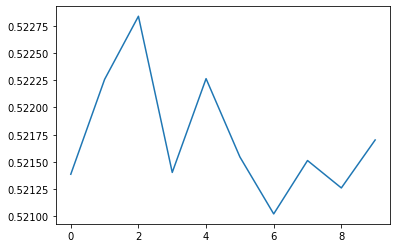

In [ ]:
chk_point = ModelCheckpoint(filepath='stock_predict_4-1-set.h5')
csv_logger = CSVLogger(filename='stock_predict_4-1-set.log', separator=',', append=False)
running = LambdaCallback(on_train_begin = lambda logs: next(r))

print(datetime.datetime.today())
model = make_model()
model.load_weights("stock_predict_4-1-set.h5") 

for i in range(8):

  # print(datetime.datetime.today())
  # model = make_model()
  # model.load_weights("stock_predict_4-1-set.h5") 

  #
  tracemalloc.start()

  for l in range(2):
    X, y, sample_weight = G2_1(ts_data, ts_code, market_index_data,\
                    pct_of_stock=0.1, edge=10.0,\
                    shuffle = 0, y_cate = 1, generator = 0\
                    #  batch_size=batch_size, repeat_time = 2\
                     )
    history = model.fit(X, y, sample_weight = sample_weight,\
                    # steps_per_epoch = batch_size,\
                    epochs = 10,\
                    verbose = 2,\
                    callbacks = [chk_point, csv_logger, running],\
                    batch_size = batch_size,
                    # validation_data = G1(ts_data, ts_code, mark_index_data, pct_of_stock=0.1, edge=10.0,\
                    # shuffle = 0, y_cate = 1, batchsize=batch_size)
                    validation_split = 0.1
                    )
    # history = model.fit(X_t, y_t, batch_size = 1024, epochs = '20,\
    #             # validation_split = 0.1, shuffle = True, \
    #             class_weight = cls_weight,\
    #             validation_data = (X_v ,y_v),\
    #             # callbacks = [tbCallBack]\
    #             callbacks = [chk_point],\
    #             # initial_epoch = 5 
    #             ) 

    model.save_weights("stock_predict_4-1-set.h5")
  model.save_weights("stock_predict_4-1-set_a.h5")

  # del model
  # gc.collect()
  
  #
  snapshot = tracemalloc.take_snapshot()
  top_stats = snapshot.statistics('lineno')
  print("[ Top 10 ]")
  for stat in top_stats[:10]:
    print(stat)
    

plt.plot(history.history["acc"]) 
print(datetime.datetime.today())

In [ ]:
show_mem()

Gen RAM Free: 7.3 GB  | Proc size: 24.0 GB


In [ ]:
print(sys.getsizeof(G2))

136


In [ ]:
K.clear_session()

In [ ]:
# del x
# del y
# del X
# del sample_weight
# del stk_data
# del model
del history
print("collect",gc.collect())


collect 296


#Model 1: CNN

##model 1-1: CNN + LSTM

In [ ]:
K.clear_session()

input = layers.Input(shape = (window_size, factor_num - 2 ,1))

model = layers.Conv2D(32, kernel_size = 4)(input)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Reshape((-1, 32))(model)

model = layers.Conv1D(32, kernel_size = 5)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Conv1D(64, kernel_size = 5)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Conv1D(256, kernel_size = 5)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Conv1D(512, kernel_size = 5)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.LSTM(64)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(32)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(1)(model)

model = Model(inputs = input, outputs = model)

opt = optimizers.RMSprop(lr = 0.001, decay = 0.001)

model.compile(loss = "mse", optimizer = opt)

model.summary()

NameError: ignored

###dataset 1-1

In [ ]:

pct_of_stock  = 0.004
stock_qty = len(ts_code)

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

for i in index:
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
      if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-1,:-2].max()
        min_price = ohlct[:-1,:-2].min()
        scale = max_price - min_price
        ohlct[:-1,:-2] = ([ohlct[:-1,:-2] - min_price]) /scale

        x.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1)])

        # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
        ohlct[-1,-1] = (ohlct[-1,-1] + 10.0) / 20.0
        y.extend([ohlct[-1,-1]])



X = np.array(x)
y = np.array(y)


# upsample
# dis = district
dis_count, dis_edge = np.histogram(y, bins = 20)

dis_count_max = dis_count.max() * 4

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[(d*100//5).astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

length = X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

X = X[index]
y = y[index]

index = random.sample(range(0,length), int(length / 4))

X = X[index]
y = y[index]

print(X.shape)
print(X[1])
print(y[0])

###draw data distribution 1-1

In [ ]:
plt.hist(y, bins = 20)

###training 1-1

In [ ]:
# model.load_weights("stock_predict_3_1-1.h5")

history = model.fit(X, y, batch_size = 1024, epochs = 240,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-1.h5")

###drawing validation 1-1

In [ ]:
# model.load_weights("stock_predict_3_1-1.h5")

history = model.fit(X, y, batch_size = 1024, epochs = 240,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-1.h5")

##model 1-2: CNN

In [ ]:
K.clear_session()

input = layers.Input(shape = (window_size, factor_num - 1 ,1))


model_1 = layers.Conv2D(32, kernel_size =(1,4))(input)
model_1 = layers.Activation("relu")(model_1)
model_1 = layers.BatchNormalization()(model_1)
model_1 = layers.Dropout(0.5)(model_1)

model_1 = layers.Reshape((-1, 32))(model_1)

# model_1 = layers.Conv1D(32, kernel_size = 5)(model_1)
# model_1 = layers.Activation("relu")(model_1)
# model_1 = layers.BatchNormalization()(model_1)
# model_1 = layers.Dropout(0.5)(model_1)

# model_1 = layers.Conv1D(64, kernel_size = 5)(model_1)
# model_1 = layers.Activation("relu")(model_1)
# model_1 = layers.BatchNormalization()(model_1)
# model_1 = layers.Dropout(0.5)(model_1)

# model_1 = layers.Conv1D(128, kernel_size = 5)(model_1)
# model_1 = layers.Activation("relu")(model_1)
# model_1 = layers.BatchNormalization()(model_1)
# model_1 = layers.Dropout(0.5)(model_1)


model_5 = layers.Conv2D(32, kernel_size =(5,4))(input)
model_5 = layers.Activation("relu")(model_5)
model_5 = layers.BatchNormalization()(model_5)
model_5 = layers.Dropout(0.5)(model_5)

model_5 = layers.Reshape((-1, 32))(model_5)

# model_5 = layers.Conv1D(64, kernel_size = 5)(model_5)
# model_5 = layers.Activation("relu")(model_5)
# model_5 = layers.BatchNormalization()(model_5)
# model_5 = layers.Dropout(0.5)(model_5)

# model_5 = layers.Conv1D(128, kernel_size = 5)(model_5)
# model_5 = layers.Activation("relu")(model_5)
# model_5 = layers.BatchNormalization()(model_5)
# model_5 = layers.Dropout(0.5)(model_5)

# model_5 = layers.Conv1D(256, kernel_size = 5)(model_5)
# model_5 = layers.Activation("relu")(model_5)
# model_5 = layers.BatchNormalization()(model_5)
# model_5 = layers.Dropout(0.5)(model_5)


model_20 = layers.Conv2D(32, kernel_size =(20,4))(input)
model_20 = layers.Activation("relu")(model_20)
model_20 = layers.BatchNormalization()(model_20)
model_20 = layers.Dropout(0.5)(model_20)

model_20 = layers.Reshape((-1, 32))(model_20)

# model_20 = layers.Conv1D(64, kernel_size = 20)(model_20)
# model_20 = layers.Activation("relu")(model_20)
# model_20 = layers.BatchNormalization()(model_20)
# model_20 = layers.Dropout(0.5)(model_20)

# model_20 = layers.Conv1D(128, kernel_size = 20)(model_20)
# model_20 = layers.Activation("relu")(model_20)
# model_20 = layers.BatchNormalization()(model_20)
# model_20 = layers.Dropout(0.5)(model_20)

# model_20 = layers.Conv1D(256, kernel_size = 20)(model_20)
# model_20 = layers.Activation("relu")(model_20)
# model_20 = layers.BatchNormalization()(model_20)
# model_20 = layers.Dropout(0.5)(model_20)


model_30 = layers.Conv2D(32, kernel_size =(30,4))(input)
model_30 = layers.Activation("relu")(model_30)
model_30 = layers.BatchNormalization()(model_30)
model_30 = layers.Dropout(0.5)(model_30)

model_30 = layers.Reshape((-1, 32))(model_30)

# model_30 = layers.Conv1D(64, kernel_size = 30)(model_30)
# model_30 = layers.Activation("relu")(model_30)
# model_30 = layers.BatchNormalization()(model_30)
# model_30 = layers.Dropout(0.5)(model_30)

# # model_30 = layers.Conv1D(64, kernel_size = 30)(model_30)
# # model_30 = layers.Activation("relu")(model_30)
# # model_30 = layers.BatchNormalization()(model_30)
# # model_30 = layers.Dropout(0.5)(model_30)

# model_30 = layers.Conv1D(256, kernel_size = 30)(model_30)
# model_30 = layers.Activation("relu")(model_30)
# model_30 = layers.BatchNormalization()(model_30)
# model_30 = layers.Dropout(0.5)(model_30)



model = layers.concatenate([model_1, model_5, model_20, model_30], axis = -2)

model = layers.Flatten()(model)

model = layers.Dense(64)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(32)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(1)(model)

model = Model(inputs = input, outputs = model)

opt = optimizers.RMSprop(lr = 0.001, decay = 0.001)

model.compile(loss = "mse", optimizer = opt)

model.summary()

###dataset 1-2

In [ ]:
pct_of_stock  = 0.004
stock_qty = len(ts_code)

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

for i in index:
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
      if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
        min_price = ohlct[:-predict_next_days,:-2].min()
        scale = max_price - min_price
        ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

        x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

        # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
        ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
        y.append(ohlct[-predict_next_days,-1])



X = np.array(x)
y = np.array(y)


# upsample
# dis = district
dis_count, dis_edge = np.histogram(y, bins = 20)

dis_count_max = dis_count.max() * 4

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[(d*100//5).astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

length = X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

X = X[index]
y = y[index]

index = random.sample(range(0,length), int(length / 4))

X = X[index]
y = y[index]

print(X.shape)
print(X[1])
print(y[0])

###draw data distribution 1-2

In [ ]:
plt.hist(y, bins = 20)

###training 1-2

In [ ]:
model.load_weights("stock_predict_3_1-2.h5")

history = model.fit(X, y, batch_size = 1024, epochs = 16,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-2.h5")

###drawing validation 1-2

In [ ]:

stock_qty = len(ts_code)

index = np.random.randint(0, stock_qty)

                      
x_plot = []
y_plot = []
yy_plot = []

stk_data = result[result.code == ts_code.iloc[index]["code"]]
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
  for l in range(days_from_ipo, length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])

      # ohlct[-1,-1] = (ohlct[-1,-1] + 10.0) / 20.0
      y_plot.extend([ohlct[-predict_next_days,-1]])

  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  # yy_plot = np.array(yy_plot)
  print(ts_code.iloc[index])    

else:
  print("data too short, try again!")

In [ ]:
model.load_weights("stock_predict_3_1-2.h5")
p = model.predict(X_plot).reshape(-1)

p = p * 20.0 - 10.0

plt.figure(figsize=(15,4.8))
plt.plot(y_plot[-100:], color="blue")
plt.plot(p[-100:], color="red")

In [ ]:
model.load_weights("stock_predict_3_1-2.h5")
model.evaluate(X, y)

In [ ]:
model.load_weights("stock_predict_3_1-2.h5")
model.evaluate(X_plot, y_plot)

##model 1-3: CNN

In [ ]:
def make_model(summary = False):
  K.clear_session()

  input = layers.Input(shape = (window_size, factor_num - 1 ,1))


  model_1 = layers.Conv2D(256, kernel_size =(1,4))(input)
  model_1 = layers.Activation("relu")(model_1)
  model_1 = layers.BatchNormalization()(model_1)
  model_1 = layers.Dropout(0.5)(model_1)

  model_1 = layers.Reshape((-1, 256))(model_1)



  model_5 = layers.Conv2D(256, kernel_size =(5,4))(input)
  model_5 = layers.Activation("relu")(model_5)
  model_5 = layers.BatchNormalization()(model_5)
  model_5 = layers.Dropout(0.5)(model_5)

  model_5 = layers.Reshape((-1, 256))(model_5)



  model_20 = layers.Conv2D(256, kernel_size =(20,4))(input)
  model_20 = layers.Activation("relu")(model_20)
  model_20 = layers.BatchNormalization()(model_20)
  model_20 = layers.Dropout(0.5)(model_20)

  model_20 = layers.Reshape((-1, 256))(model_20)



  model_30 = layers.Conv2D(256, kernel_size =(30,4))(input)
  model_30 = layers.Activation("relu")(model_30)
  model_30 = layers.BatchNormalization()(model_30)
  model_30 = layers.Dropout(0.5)(model_30)

  model_30 = layers.Reshape((-1, 256))(model_30)


  model_60 = layers.Conv2D(256, kernel_size =(60,4))(input)
  model_60 = layers.Activation("relu")(model_60)
  model_60 = layers.BatchNormalization()(model_60)
  model_60 = layers.Dropout(0.5)(model_60)

  model_60 = layers.Reshape((-1, 256))(model_60)


  model_90 = layers.Conv2D(256, kernel_size =(90,4))(input)
  model_90 = layers.Activation("relu")(model_90)
  model_90 = layers.BatchNormalization()(model_90)
  model_90 = layers.Dropout(0.5)(model_90)

  model_90 = layers.Reshape((-1, 256))(model_90)



  model = layers.concatenate([model_1, model_5, model_20, model_30, model_60, model_90], axis = -2)

  model = layers.Flatten()(model)

  # model = layers.Dense(64)(model)
  # model = layers.Activation("relu")(model)
  # model = layers.BatchNormalization()(model)
  # model = layers.Dropout(0.5)(model)

  model = layers.Dense(32)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)


  model = layers.Dense(16)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  # model = layers.Dense(1)(model)

  model = layers.Dense(4)(model)
  model = layers.Activation("softmax")(model)

  model = Model(inputs = input, outputs = model)

  # opt = optimizers.RMSprop(lr = 0.001, decay = 0.001)
  opt = optimizers.Adam(lr = 0.005, decay = 0.001)

  # model.compile(loss = "mse", optimizer = opt)
  model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["acc"])

  if(summary == True):
    model.summary()

  return model

###dataset 1-3

In [ ]:
pct_of_stock  = 0.004
stock_qty = len(ts_code)

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

for i in index:
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
      if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
        min_price = ohlct[:-predict_next_days,:-2].min()
        scale = max_price - min_price
        ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

        x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

        # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
        ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
        y.append(ohlct[-predict_next_days,-1])



X = np.array(x)
y = np.array(y)


# upsample
# dis = district
dis_count, dis_edge = np.histogram(y, bins = 20)

dis_count_max = dis_count.max() * 4

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[(d*100//5).astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

length = X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

X = X[index]
y = y[index]

index = random.sample(range(0,length), int(length / 4))

X = X[index]
y = y[index]

print(X.shape)
print(X[1])
print(y[0])

In [ ]:
#20200824


###draw data distribution 1-3

In [ ]:
plt.hist(y, bins = 20)

###training 1-3

In [ ]:
# model.load_weights("stock_predict_3_1-3.h5")

history = model.fit(X, y, batch_size = 256, epochs = 64,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-3.h5")

In [ ]:
#reset model params file
model = make_model()
model.save_weights("stock_predict_3_1-3-set.h5")

In [ ]:
#20200824

chk_point = ModelCheckpoint(filepath='stock_predict_3_1-3-set.h5')
# model.load_weights("stock_predict_3_1-3-set.h5")


for i in range(4):
  print(datetime.datetime.today())
  model = make_model()
  model.load_weights("stock_predict_3_1-3-set.h5")  

  for l in range(2):
    history = model.fit(X_t, y_t, batch_size = 1024, epochs = 10,\
                # validation_split = 0.1, shuffle = True, \
                class_weight = cls_weight,\
                validation_data = (X_v ,y_v),\
                # callbacks = [tbCallBack]\
                callbacks = [chk_point],\
                # initial_epoch = 5 
                ) 

    model.save_weights("stock_predict_3_1-3-set.h5")

  model.save_weights("stock_predict_3_1-3-set_a.h5")
  del model
  gc.collect()
plt.plot(history.history["acc"])
print(datetime.datetime.today())

###drawing validation 1-3

In [ ]:

stock_qty = len(ts_code)

index = np.random.randint(0, stock_qty)

                      
x_plot = []
y_plot = []
yy_plot = []

stk_data = result[result.code == ts_code.iloc[index]["code"]]
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
  for l in range(days_from_ipo, length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])

      # ohlct[-1,-1] = (ohlct[-1,-1] + 10.0) / 20.0
      y_plot.extend([ohlct[-predict_next_days,-1]])

  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  # yy_plot = np.array(yy_plot)
  print(ts_code.iloc[index])    

else:
  print("data too short, try again!")

In [ ]:
model.load_weights("stock_predict_3_1-3.h5")
p = model.predict(X_plot).reshape(-1)

p = p * 20.0 - 10.0

plt.figure(figsize=(15,4.8))
plt.plot(y_plot[-100:], color="blue")
plt.plot(p[-100:], color="red")

In [ ]:
model.load_weights("stock_predict_3_1-3.h5")
model.evaluate(X, y)

In [ ]:
model.load_weights("stock_predict_3_1-3.h5")
model.evaluate(X_plot, y_plot)

##model 1-4: CNN + LSTM

In [ ]:
K.clear_session()

input = layers.Input(shape = (window_size, factor_num - 1 ,1))


model_1 = layers.Conv2D(256, kernel_size =(1,4))(input)
model_1 = layers.Activation("relu")(model_1)
model_1 = layers.BatchNormalization()(model_1)
model_1 = layers.Dropout(0.5)(model_1)

model_1 = layers.Reshape((-1,256))(model_1)

model_1 = layers.LSTM(256)(model_1)



model_5 = layers.Conv2D(256, kernel_size =(5,4))(input)
model_5 = layers.Activation("relu")(model_5)
model_5 = layers.BatchNormalization()(model_5)
model_5 = layers.Dropout(0.5)(model_5)

model_5 = layers.Reshape((-1,256))(model_5)

model_5 = layers.LSTM(256)(model_5)

model_10 = layers.Conv2D(256, kernel_size =(5,4))(input)
model_10 = layers.Activation("relu")(model_10)
model_10 = layers.BatchNormalization()(model_10)
model_10 = layers.Dropout(0.5)(model_10)

model_10 = layers.Reshape((-1,256))(model_10)

model_10 = layers.LSTM(256)(model_10)

model_20 = layers.Conv2D(256, kernel_size =(20,4))(input)
model_20 = layers.Activation("relu")(model_20)
model_20 = layers.BatchNormalization()(model_20)
model_20 = layers.Dropout(0.5)(model_20)

model_20 = layers.Reshape((-1,256))(model_20)

model_20 = layers.LSTM(256)(model_20)




model_30 = layers.Conv2D(256, kernel_size =(30,4))(input)
model_30 = layers.Activation("relu")(model_30)
model_30 = layers.BatchNormalization()(model_30)
model_30 = layers.Dropout(0.5)(model_30)

model_30 = layers.Reshape((-1,256))(model_30)

model_30 = layers.LSTM(256)(model_30)



model = layers.concatenate([model_1, model_5, model_10, model_20, model_30], axis = -1)

model = layers.Dense(256)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(128)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(64)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(32)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(1)(model)

model = Model(inputs = input, outputs = model)

opt = optimizers.RMSprop(lr = 0.001, decay = 0.001)

model.compile(loss = "mse", optimizer = opt)

model.summary()

###dataset 1-4

In [ ]:
pct_of_stock  = 0.01
stock_qty = len(ts_code)

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

for i in index:
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
      if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
        min_price = ohlct[:-predict_next_days,:-2].min()
        scale = max_price - min_price
        ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

        x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

        # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
        ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
        y.append(ohlct[-predict_next_days,-1])



X = np.array(x)
y = np.array(y)


# upsample
# dis = district
dis_count, dis_edge = np.histogram(y, bins = 20)

dis_count_max = dis_count.max() * 4

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[(d*100//5).astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

length = X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

X = X[index]
y = y[index]

index = random.sample(range(0,length), int(length / 4))

X = X[index]
y = y[index]

print(X.shape)
print(X[1])
print(y[0])

###draw data distribution 1-4

In [ ]:
plt.hist(y, bins = 20)

###training 1-4

In [ ]:
model.load_weights("stock_predict_3_1-4.h5")

history = model.fit(X, y, batch_size = 1024, epochs = 24,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-4.h5")

###drawing validation 1-4

In [ ]:

stock_qty = len(ts_code)

index = np.random.randint(0, stock_qty)

                      
x_plot = []
y_plot = []
yy_plot = []

stk_data = result[result.code == ts_code.iloc[index]["code"]]
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
  for l in range(days_from_ipo, length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])

      # ohlct[-1,-1] = (ohlct[-1,-1] + 10.0) / 20.0
      y_plot.extend([ohlct[-predict_next_days,-1]])

  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  # yy_plot = np.array(yy_plot)
  print(ts_code.iloc[index])    

else:
  print("data too short, try again!")

In [ ]:
model.load_weights("stock_predict_3_1-4.h5")
p = model.predict(X_plot).reshape(-1)

p = p * 20.0 - 10.0

plt.figure(figsize=(15,4.8))
plt.plot(y_plot[-100:], color="blue")
plt.plot(p[-100:], color="red")

In [ ]:
model.load_weights("stock_predict_3_1-4.h5")
model.evaluate(X, y)

In [ ]:
model.load_weights("stock_predict_3_1-4.h5")
model.evaluate(X_plot, y_plot)

##model 1-5: CNN + LSTM with dif params

In [ ]:
K.clear_session()

input = layers.Input(shape = (window_size, factor_num - 1 ,1))


model_1 = layers.Conv2D(64, kernel_size =(1,4))(input)
model_1 = layers.Activation("relu")(model_1)
model_1 = layers.BatchNormalization()(model_1)
model_1 = layers.Dropout(0.5)(model_1)

model_1 = layers.Reshape((-1,64))(model_1)

model_1 = layers.LSTM(256)(model_1)



model_5 = layers.Conv2D(128, kernel_size =(5,4))(input)
model_5 = layers.Activation("relu")(model_5)
model_5 = layers.BatchNormalization()(model_5)
model_5 = layers.Dropout(0.5)(model_5)

model_5 = layers.Reshape((-1,128))(model_5)

model_5 = layers.LSTM(256)(model_5)

model_10 = layers.Conv2D(256, kernel_size =(5,4))(input)
model_10 = layers.Activation("relu")(model_10)
model_10 = layers.BatchNormalization()(model_10)
model_10 = layers.Dropout(0.5)(model_10)

model_10 = layers.Reshape((-1,256))(model_10)

model_10 = layers.LSTM(256)(model_10)

model_20 = layers.Conv2D(512, kernel_size =(20,4))(input)
model_20 = layers.Activation("relu")(model_20)
model_20 = layers.BatchNormalization()(model_20)
model_20 = layers.Dropout(0.5)(model_20)

model_20 = layers.Reshape((-1,512))(model_20)

model_20 = layers.LSTM(256)(model_20)



model_30 = layers.Conv2D(1024, kernel_size =(30,4))(input)
model_30 = layers.Activation("relu")(model_30)
model_30 = layers.BatchNormalization()(model_30)
model_30 = layers.Dropout(0.5)(model_30)

model_30 = layers.Reshape((-1,1024))(model_30)

model_30 = layers.LSTM(256)(model_30)



model = layers.concatenate([model_1, model_5, model_10, model_20, model_30], axis = -1)

model = layers.Dense(256)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(128)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(64)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(32)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(1)(model)

model = Model(inputs = input, outputs = model)

opt = optimizers.RMSprop(lr = 0.001, decay = 0.001)

model.compile(loss = "mse", optimizer = opt)

model.summary()

###dataset 1-5

In [ ]:
pct_of_stock  = 0.01
stock_qty = len(ts_code)

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

for i in index:
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
      if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
        min_price = ohlct[:-predict_next_days,:-2].min()
        scale = max_price - min_price
        ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

        x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

        # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
        ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
        y.append(ohlct[-predict_next_days,-1])



X = np.array(x)
y = np.array(y)


# upsample
# dis = district
dis_count, dis_edge = np.histogram(y, bins = 20)

dis_count_max = dis_count.max() * 4

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[(d*100//5).astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

length = X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

X = X[index]
y = y[index]

index = random.sample(range(0,length), int(length / 4))

X = X[index]
y = y[index]

print(X.shape)
print(X[1])
print(y[0])

###draw data distribution 1-5

In [ ]:
plt.hist(y, bins = 20)

###training 1-5

In [ ]:
model.load_weights("stock_predict_3_1-5.h5")

history = model.fit(X, y, batch_size = 1024, epochs = 24,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-5.h5")

In [ ]:
model.load_weights("stock_predict_3_1-5.h5")

history = model.fit(X, y, batch_size = 1024, epochs = 64,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-5.h5")

###drawing validation 1-5

In [ ]:

stock_qty = len(ts_code)

index = np.random.randint(0, stock_qty)

                      
x_plot = []
y_plot = []
yy_plot = []

stk_data = result[result.code == ts_code.iloc[index]["code"]]
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
  for l in range(days_from_ipo, length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])

      # ohlct[-1,-1] = (ohlct[-1,-1] + 10.0) / 20.0
      y_plot.extend([ohlct[-predict_next_days,-1]])

  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  # yy_plot = np.array(yy_plot)
  print(ts_code.iloc[index])    

else:
  print("data too short, try again!")

In [ ]:
model.load_weights("stock_predict_3_1-5.h5")
p = model.predict(X_plot).reshape(-1)

p = p * 20.0 - 10.0

plt.figure(figsize=(15,4.8))
plt.plot(y_plot[-100:], color="blue")
plt.plot(p[-100:], color="red")

In [ ]:
model.load_weights("stock_predict_3_1-5.h5")
model.evaluate(X, y)

In [ ]:
model.load_weights("stock_predict_3_1-5.h5")
model.evaluate(X_plot, y_plot)

###get data of specific code

In [ ]:
s_code = "sh.000016"

s_data_file = s_code + ".csv"

In [ ]:

s_code = "sh.000016"

s_data_file = s_code + ".csv"

bs.login()

rs = bs.query_history_k_data_plus(s_code, ",".join(data_fields),\
                          start_date = start_date, end_date = end_date,\
                            frequency = "d", adjustflag = adjustflag)

data_list = []
while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
        data_list.append(row_data)
s_result = pd.DataFrame(data_list, columns = rs.fields)
s_result.to_csv(s_data_file)
print(s_result.head())

bs.logout()

###dataset of specific code

In [ ]:
x = []
y = []

stk_data = pd.read_csv(s_data_file)
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
 for l in range(days_from_ipo, length - window_size - predict_next_days):
  ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
  if np.all(ohlct[:, -2] != 1) and \
     np.all(ohlct[:,-1] > -10.0) and \
      np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
  min_price = ohlct[:-predict_next_days,:-2].min()
  scale = max_price - min_price
  ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

  x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

  # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
  ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
  y.append(ohlct[-predict_next_days,-1])


s_X = np.array(x)
s_y = np.array(y)


# upsample
# dis = district
dis_count, dis_edge = np.histogram(s_y, bins = 20)

dis_count_max = dis_count.max() * 4

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[(d*100//5).astype(int)]), \
                                0 , s_y)

s_X = np.repeat(s_X, time_count, axis = 0)
s_y = np.repeat(s_y, time_count, axis = 0)

length = s_X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

s_X = s_X[index]
s_y = s_y[index]

index = random.sample(range(0,length), int(length / 4))

s_X = s_X[index]
s_y = s_y[index]

print(s_X.shape)
print(s_X[1])
print(s_y[0])

###training basing on model1-5

In [ ]:
# model.load_weights("stock_predict_3_1-5.h5")
model.load_weights(s_data_file + ".h5")

history = model.fit(s_X, s_y, batch_size = 128, epochs = 24,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
# plt.plot(history.history["acc"])
plt.plot(history.history["loss"])
model.save_weights(s_data_file + ".h5")

###get more data for specific code

In [ ]:
bs.login()

s_date = "2018-06-01"
e_date = "2019-09-30"

rs = bs.query_history_k_data_plus(s_code, ",".join(data_fields),\
                          start_date = s_date, end_date = e_date,\
                            frequency = "d", adjustflag = adjustflag)

data_list = []
while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
        data_list.append(row_data)
p_result = pd.DataFrame(data_list, columns = rs.fields)

print(p_result.head())

bs.logout()

In [ ]:
print(p_result.loc[0])

In [ ]:
print(p_result.count())

###predict for specific code

In [ ]:
                      
x_plot = []
y_plot = []

stk_data = p_result
length = len(stk_data)
if ((length - predict_next_days) > window_size):
  for l in range(length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    ohlct = ohlct.astype("float")
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])

      # ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
      y_plot.extend([ohlct[-predict_next_days,-1]])

  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  # yy_plot = np.array(yy_plot)  

else:
  print("data too short, try again!")

In [ ]:
model.load_weights("sh.000016.csv.h5")
# model.load_weights("stock_predict_3_1-5.h5")

p = model.predict(X_plot).reshape(-1)

p = p * 20.0 - 10.0

plt.figure(figsize=(15,4.8))
plt.plot(y_plot, color="blue")
plt.plot(p, color="red")

##model 1-6: CNN + LSTM with dif params by crossentrpy

In [ ]:
K.clear_session()

input = layers.Input(shape = (window_size, factor_num - 1 ,1))


model_1 = layers.Conv2D(64, kernel_size =(1,4))(input)
model_1 = layers.Activation("relu")(model_1)
model_1 = layers.BatchNormalization()(model_1)
model_1 = layers.Dropout(0.5)(model_1)

model_1 = layers.Reshape((-1,64))(model_1)

model_1 = layers.LSTM(256)(model_1)



model_5 = layers.Conv2D(128, kernel_size =(5,4))(input)
model_5 = layers.Activation("relu")(model_5)
model_5 = layers.BatchNormalization()(model_5)
model_5 = layers.Dropout(0.5)(model_5)

model_5 = layers.Reshape((-1,128))(model_5)

model_5 = layers.LSTM(256)(model_5)

model_10 = layers.Conv2D(256, kernel_size =(5,4))(input)
model_10 = layers.Activation("relu")(model_10)
model_10 = layers.BatchNormalization()(model_10)
model_10 = layers.Dropout(0.5)(model_10)

model_10 = layers.Reshape((-1,256))(model_10)

model_10 = layers.LSTM(256)(model_10)

model_20 = layers.Conv2D(512, kernel_size =(20,4))(input)
model_20 = layers.Activation("relu")(model_20)
model_20 = layers.BatchNormalization()(model_20)
model_20 = layers.Dropout(0.5)(model_20)

model_20 = layers.Reshape((-1,512))(model_20)

model_20 = layers.LSTM(256)(model_20)



model_30 = layers.Conv2D(1024, kernel_size =(30,4))(input)
model_30 = layers.Activation("relu")(model_30)
model_30 = layers.BatchNormalization()(model_30)
model_30 = layers.Dropout(0.5)(model_30)

model_30 = layers.Reshape((-1,1024))(model_30)

model_30 = layers.LSTM(256)(model_30)



model = layers.concatenate([model_1, model_5, model_10, model_20, model_30], axis = -1)

model = layers.Dense(256)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(128)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(64)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(32)(model)
model = layers.Activation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(4)(model)
model = layers.Activation("softmax")(model)

model = Model(inputs = input, outputs = model)

opt = optimizers.RMSprop(lr = 0.001, decay = 0.001)

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["acc"])

model.summary()

###dataset 1-6

In [ ]:
pct_of_stock  = 0.04
stock_qty = len(ts_code)
edge = 3.0

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

for i in index:
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
      if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
        min_price = ohlct[:-predict_next_days,:-2].min()
        scale = max_price - min_price
        ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

        x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

        # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
        if ohlct[-predict_next_days,-1] <= -edge:
          y.append(0)
        elif ohlct[-predict_next_days,-1] > -edge and \
          ohlct[-predict_next_days,-1] <= 0:
          y.append(1)
        elif ohlct[-predict_next_days,-1] > 0 and \
          ohlct[-predict_next_days,-1] <= edge:
          y.append(2)
        else:
          y.append(3)


X = np.array(x)
y = np.array(y)


# upsample
# dis = district

dis_count, dis_edge = np.histogram(y, bins = 4)

dis_count_max = dis_count.max()

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[d.astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

# shuffle dataset

length = X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

X = X[index]
y = y[index]

# index = random.sample(range(0,length), int(length / 4))

X = X[index]
y = y[index]

y = utils.to_categorical(y)

print(X.shape)
print(X[1])
print(y[0])

###draw data distribution 1-6

In [ ]:
plt.hist(y, bins = 3)

###training 1-6

In [ ]:
model.load_weights("stock_predict_3_1-6.h5")

history = model.fit(X, y, batch_size = 1024, epochs = 64,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
plt.plot(history.history["acc"])
# plt.plot(history.history["loss"])
model.save_weights("stock_predict_3_1-6.h5")

###drawing validation 1-6

In [ ]:

stock_qty = len(ts_code)

index = np.random.randint(0, stock_qty)

                      
x_plot = []
y_plot = []
yy_plot = []

stk_data = result[result.code == ts_code.iloc[index]["code"]]
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
  for l in range(days_from_ipo, length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])

      # ohlct[-1,-1] = (ohlct[-1,-1] + 10.0) / 20.0
      if ohlct[-predict_next_days,-1] <= -edge:
        y_plot.append(0)
      elif ohlct[-predict_next_days,-1] > -edge and \
        ohlct[-predict_next_days,-1] <= 0:
        y_plot.append(1)
      elif ohlct[-predict_next_days,-1] > 0 and \
        ohlct[-predict_next_days,-1] <= edge:
        y_plot.append(2)
      else:
        y_plot.append(3)


  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)

  # yy_plot = np.array(yy_plot)
  print(ts_code.iloc[index])    

else:
  print("data too short, try again!")

In [ ]:
model.load_weights("stock_predict_3_1-6.h5")
p = model.predict(X_plot)
p = np.apply_along_axis(lambda d: d.argmax() + 1, 1, p)


plt.figure(figsize=(15,4.8))
plt.plot(y_plot[-100:], color="blue")
plt.plot(p[-100:], color="red")

In [ ]:
np.apply_along_axis(lambda d: d.argmax(), 1, p)

In [ ]:
model.load_weights("stock_predict_3_1-6.h5")
model.evaluate(X, y)

In [ ]:
model.load_weights("stock_predict_3_1-6.h5")

model.evaluate(X_plot, utils.to_categorical(y_plot))

###get data of specific code 1-6

In [ ]:
s_code = "sh.000016"

s_data_file = s_code + "_1-6.csv"

In [ ]:

s_code = "sh.000016"

s_data_file = s_code + "_1-6.csv"

bs.login()

rs = bs.query_history_k_data_plus(s_code, ",".join(data_fields),\
                          start_date = start_date, end_date = end_date,\
                            frequency = "d", adjustflag = adjustflag)

data_list = []
while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
        data_list.append(row_data)
s_result = pd.DataFrame(data_list, columns = rs.fields)
s_result.to_csv(s_data_file)
print(s_result.head())

bs.logout()

###dataset of specific code 1-6

In [ ]:
edge = 3.0

x = []
y = []

stk_data = pd.read_csv(s_data_file)
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
 for l in range(days_from_ipo, length - window_size - predict_next_days):
  ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
  if np.all(ohlct[:, -2] != 1) and \
     np.all(ohlct[:,-1] > -10.0) and \
      np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
  min_price = ohlct[:-predict_next_days,:-2].min()
  scale = max_price - min_price
  ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

  x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

  # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
  # ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
  if ohlct[-predict_next_days,-1] <= -edge:
    y.append(0)
  elif ohlct[-predict_next_days,-1] > -edge and \
    ohlct[-predict_next_days,-1] <= 0:
    y.append(1)
  elif ohlct[-predict_next_days,-1] > 0 and \
    ohlct[-predict_next_days,-1] <= edge:
    y.append(2)
  else:
    y.append(3)



s_X = np.array(x)
s_y = np.array(y)


# upsample
# dis = district

dis_count, dis_edge = np.histogram(y, bins = 4)

dis_count_max = dis_count.max()

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[d.astype(int)]), \
                                0 , s_y)

s_X = np.repeat(s_X, time_count, axis = 0)
s_y = np.repeat(s_y, time_count, axis = 0)


#shuffle
length = s_X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

s_X = s_X[index]
s_y = s_y[index]

# index = random.sample(range(0,length), int(length / 4))

s_X = s_X[index]
s_y = s_y[index]

s_y = utils.to_categorical(s_y)

print(s_X.shape)
print(s_X[1])
print(s_y[0])

###training basing on model1-6

In [ ]:
model.load_weights("stock_predict_3_1-6.h5")
# model.load_weights(s_data_file + ".h5")

history = model.fit(s_X, s_y, batch_size = 128, epochs = 64,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
plt.plot(history.history["acc"])
# plt.plot(history.history["loss"])
model.save_weights(s_data_file + ".h5")

###get more data for specific code 1-6



In [ ]:
bs.login()

s_date = "2018-06-01"
e_date = "2019-11-13"

rs = bs.query_history_k_data_plus(s_code, ",".join(data_fields),\
                          start_date = s_date, end_date = e_date,\
                            frequency = "d", adjustflag = adjustflag)

data_list = []
while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
        data_list.append(row_data)
p_result = pd.DataFrame(data_list, columns = rs.fields)

print(p_result.head())

bs.logout()

In [ ]:
print(p_result.loc[0])

In [ ]:
print(p_result.count())

###predict for specific code 1-6

In [ ]:
                      
x_plot = []
y_plot = []

stk_data = p_result
length = len(stk_data)
if ((length - predict_next_days) > window_size):
  for l in range(length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    ohlct = ohlct.astype("float")
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])

      # ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
      if ohlct[-predict_next_days,-1] <= -edge:
        y_plot.append(0)
      elif ohlct[-predict_next_days,-1] > -edge and \
        ohlct[-predict_next_days,-1] <= 0:
        y_plot.append(1)
      elif ohlct[-predict_next_days,-1] > 0 and \
        ohlct[-predict_next_days,-1] <= edge:
        y_plot.append(2)
      else:
        y_plot.append(3)


  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  # yy_plot = np.array(yy_plot)  

else:
  print("data too short, try again!")

In [ ]:
model.load_weights(s_data_file + ".h5")
# model.load_weights("stock_predict_3_1-6.h5")

p = model.predict(X_plot)
p = np.apply_along_axis(lambda d: d.argmax() + 1, 1, p)

plt.figure(figsize=(15,4.8))
plt.plot(y_plot, color="blue")
plt.plot(p, color="red")

In [ ]:
model.load_weights(s_data_file + ".h5")
model.evaluate(X_plot, utils.to_categorical(y_plot))

##model 1-7: CNN + LSTM with dif params by crossentrpy for next few days

In [ ]:
predict_next_days = 20

In [ ]:
def make_model(summary = False):
  K.clear_session()
  # tf.keras.backend.clear_session()
  p_lstm = 64

  input = layers.Input(shape = (window_size, factor_num - 1 ,1))


  model_1 = layers.Conv2D(64, kernel_size =(1,4))(input)
  model_1 = layers.Activation("relu")(model_1)
  model_1 = layers.BatchNormalization()(model_1)
  model_1 = layers.Dropout(0.5)(model_1)

  model_1 = layers.Reshape((-1,64))(model_1)

  model_1 = layers.LSTM(p_lstm)(model_1)



  model_5 = layers.Conv2D(128, kernel_size =(5,4))(input)
  model_5 = layers.Activation("relu")(model_5)
  model_5 = layers.BatchNormalization()(model_5)
  model_5 = layers.Dropout(0.5)(model_5)

  model_5 = layers.Reshape((-1,128))(model_5)

  model_5 = layers.LSTM(p_lstm)(model_5)

  model_10 = layers.Conv2D(256, kernel_size =(10,4))(input)
  model_10 = layers.Activation("relu")(model_10)
  model_10 = layers.BatchNormalization()(model_10)
  model_10 = layers.Dropout(0.5)(model_10)

  model_10 = layers.Reshape((-1,256))(model_10)

  model_10 = layers.LSTM(p_lstm)(model_10)

  model_20 = layers.Conv2D(512, kernel_size =(20,4))(input)
  model_20 = layers.Activation("relu")(model_20)
  model_20 = layers.BatchNormalization()(model_20)
  model_20 = layers.Dropout(0.5)(model_20)

  model_20 = layers.Reshape((-1,512))(model_20)

  model_20 = layers.LSTM(p_lstm)(model_20)



  model_30 = layers.Conv2D(1024, kernel_size =(30,4))(input)
  model_30 = layers.Activation("relu")(model_30)
  model_30 = layers.BatchNormalization()(model_30)
  model_30 = layers.Dropout(0.5)(model_30)

  model_30 = layers.Reshape((-1,1024))(model_30)

  model_30 = layers.LSTM(p_lstm)(model_30)



  model = layers.concatenate([model_1, model_5, model_10, model_20, model_30], axis = -1)


  model = layers.Dense(2048)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)


  model = layers.Dense(1024)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(512)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(256)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(128)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(64)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(32)(model)
  model = layers.Activation("relu")(model)
  model = layers.BatchNormalization()(model)
  model = layers.Dropout(0.5)(model)

  model = layers.Dense(4)(model)
  model = layers.Activation("softmax")(model)

  model = Model(inputs = input, outputs = model)

  # opt = optimizers.RMSprop(lr = 0.0005, decay = 0.001)
  opt = optimizers.Adam(lr = 0.0005, decay = 0.001)

  model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["acc"])

  if summary:
    model.summary()

  return model

model = make_model()

###dataset 1-7

In [ ]:
pct_of_stock  = 0.2
stock_qty = len(ts_code)
edge = 10.0

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

count = 0

for i in index:
  count = count + 1
  if count%200 == 0:
    print(count)
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values
      if np.all(ohlct[:,-2] != 1) and \
        np.all(ohlct[:,-3] != 0) and \
       np.all(ohlct[:,-1] >= -10.0) and \
       np.all(ohlct[:,-1] <= 10.0) :
        max_price = ohlct[:-predict_next_days,:-3].max()
        min_price = ohlct[:-predict_next_days,:-3].min()
        scale = max_price - min_price
        ohlct[:-predict_next_days,:-3] = ([ohlct[:-predict_next_days,:-3] - min_price]) /scale

        x.append(np.expand_dims(ohlct[:-predict_next_days,:-3], axis=-1))

        next_days_pctChg = ohlct[-predict_next_days:,-1].sum()

        if next_days_pctChg  <= -edge:
          y.append(0)
        elif next_days_pctChg  > -edge and \
          next_days_pctChg  <= 0:
          y.append(1)
        elif next_days_pctChg  > 0 and \
          next_days_pctChg  <= edge:
          y.append(2)
        else:
          y.append(3)


X = np.array(x)
y = np.array(y)


# upsample
# dis = district

dis_count, dis_edge = np.histogram(y, bins = 4)

dis_count_max = dis_count.max()

dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
dis_count_max = dis_count_max + 1.0 #because dis_count plus 1 above, 
                    #here plus 1 to avoid time below to be zero

time = dis_count_max/dis_count
time = time.astype(int)

time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

# shuffle dataset

length = X.shape[0]

r_index = np.arange(length)
np.random.shuffle(r_index)

X = X[r_index]
y = y[r_index]

# r_index = random.sample(range(0,length), int(length / 4))

# X = X[r_index]
# y = y[r_index]

y = utils.to_categorical(y)

print(X.shape)
print(X[1])
print(y[0])

# X.tofile("stock_predict_3_1-7-X.dat", format="%f")
# y.tofile("stock_predict_3_1-7-y.dat", format="%f")

In [ ]:
yy = y.argmax(axis = 1)

if np.any(yy == 2): 
  print("ok")

# y[0]

###draw data distribution 1-7

In [ ]:
plt.hist(y.argmax(axis = 1), bins = 4)

###training 1-7

In [ ]:
y.shape

In [ ]:
X = np.fromfile("stock_predict_3_1-7-X.dat", dtype=np.float).reshape(26654, 90, 4, 1)
y = np.fromfile("stock_predict_3_1-7-y.dat", dtype=np.float32).reshape(26654, 4)
print(X[100])
print(y[180])

In [ ]:


model.load_weights("stock_predict_3_1-7.h5")

for t in range(20):
  history = model.fit(X, y, batch_size = 1024, epochs = 4,\
              validation_split = 0.1, shuffle = True, \
              # callbacks = [tbCallBack]\
              )

  model.save_weights("stock_predict_3_1-7.h5")

plt.plot(history.history["acc"])

###training by generator

####define a generator

In [ ]:
def gntor(ts_data, ts_code, pct_of_stock=0.05, edge=10.0, batch_size = 512, generator = True):  

  stock_qty = len(ts_code)
  # index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

  while True :

    index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))                   

    # x = []
    # y = []

    for i in index:
    # for i in range(stock_qty):

      x = []
      y = []

      stk_data = ts_data[ts_data.code == ts_code.iloc[i]["code"]]
      length = len(stk_data)
      if ((length - days_from_ipo - predict_next_days) > window_size):
        for l in range(days_from_ipo, length - window_size - predict_next_days):
          ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
              [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values.astype("float")
          if np.all(ohlct[:,-2] == 0) and \
            np.all(ohlct[:,-3] == 1) and \
          np.all(ohlct[:,-1] >= -10.0) and \
          np.all(ohlct[:,-1] <= 10.0) :
            max_price = ohlct[:-predict_next_days,:-3].max()
            min_price = ohlct[:-predict_next_days,:-3].min()
            scale = max_price - min_price
            ohlct[:-predict_next_days,:-3] = ([ohlct[:-predict_next_days,:-3] - min_price]) /scale

            x.append(np.expand_dims(ohlct[:-predict_next_days,:-3], axis=-1))

            next_days_pctChg = (ohlct[-1,-4] - ohlct[-predict_next_days,-4]) * 100 / ohlct[-predict_next_days,-4]

            if next_days_pctChg  <= -edge:
              y.append(0)
            elif next_days_pctChg  > -edge and \
              next_days_pctChg  <= 0:
              y.append(1)
            elif next_days_pctChg  > 0 and \
              next_days_pctChg  <= edge:
              y.append(2)
            else:
              y.append(3)
    # print("there")
    if len(x) > 0:
      # print("here")
      X = np.array(x)
      y = np.array(y)

      # upsample
      # dis = district

      dis_count, dis_edge = np.histogram(y, bins = 4, range=(0,3))

      dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
      dis_count_max = dis_count.max()

      time = dis_count_max/dis_count
      time = time.astype(int)

      time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
                                      0 , y)

      X = np.repeat(X, time_count, axis = 0)
      y = np.repeat(y, time_count, axis = 0)

      # shuffle dataset

      length = X.shape[0]

      r_index = np.arange(length)
      np.random.shuffle(r_index)

      X = X[r_index]
      y = y[r_index]

      # r_index = random.sample(range(0,length), int(length / 4))

      # X = X[r_index]
      # y = y[r_index]

      y = utils.to_categorical(y, num_classes=4)
      if generator:
        print("a")
        # for ll in range((length-1)//batch_size + 1):
        #   start_i = ll*batch_size
        #   end_i = start_i + batch_size
        #   if end_i <= length:
        #     yield(X[start_i:end_i],y[start_i:end_i])
        #   else:
        #     yield(X[start_i:],y[start_i:])
      else:
        return 1,2


In [ ]:
i = random.randint(0,len(ts_code))
print(i)
stk_data = result[result.code == ts_code.iloc[i]["code"]]

####define a generator 1

In [ ]:
def gntor_1(ts_data, ts_code, edge=10.0):
  stock_qty = len(ts_code)

  # print(np.sort(index))                        


  while True:
    i = random.randint(0,stock_qty-1)

    x = []
    y = []
    # if count%1 == 0:
    #   print(count)
    stk_data = ts_data[ts_data.code == ts_code.iloc[i]["code"]]
    length = len(stk_data)
    if ((length - days_from_ipo - predict_next_days) > window_size):
      for l in range(days_from_ipo, length - window_size - predict_next_days):
        ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
            [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values
        if np.all(ohlct[:,-2] != 1) and \
          np.all(ohlct[:,-3] != 0) and \
        np.all(ohlct[:,-1] >= -10.0) and \
        np.all(ohlct[:,-1] <= 10.0) :
          max_price = ohlct[:-predict_next_days,:-3].max()
          min_price = ohlct[:-predict_next_days,:-3].min()
          scale = max_price - min_price
          ohlct[:-predict_next_days,:-3] = ([ohlct[:-predict_next_days,:-3] - min_price]) /scale

          x.append(np.expand_dims(ohlct[:-predict_next_days,:-3], axis=-1))

          next_days_pctChg = (ohlct[-1,-4] - ohlct[-predict_next_days,-4]) * 100 / ohlct[-predict_next_days,-4]

          if next_days_pctChg  <= -edge:
            y.append(0)
          elif next_days_pctChg  > -edge and \
            next_days_pctChg  <= 0:
            y.append(1)
          elif next_days_pctChg  > 0 and \
            next_days_pctChg  <= edge:
            y.append(2)
          else:
            y.append(3)

      if len(x) > 0:
        X = np.array(x)
        y = np.array(y)

        # upsample
        # dis = district

        dis_count, dis_edge = np.histogram(y, bins = 4)

        dis_count_max = dis_count.max()

        dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
        dis_count_max = dis_count_max + 1.0 #because dis_count plus 1 above, 
                            #here plus 1 to avoid time below to be zero

        time = dis_count_max/dis_count
        time = time.astype(int)

        time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
                                        0 , y)

        X = np.repeat(X, time_count, axis = 0)
        y = np.repeat(y, time_count, axis = 0)

        # shuffle dataset

        length = X.shape[0]

        r_index = np.arange(length)
        np.random.shuffle(r_index)

        X = X[r_index]
        y = y[r_index]

        # r_index = random.sample(range(0,length), int(length / 4))

        # X = X[r_index]
        # y = y[r_index]

        y = utils.to_categorical(y, num_classes=4)

        batch_size = 512
        for ll in range((length-1)//batch_size + 1):
          start_i = ll*batch_size
          end_i = start_i + batch_size
          if end_i <= length:
            yield(X[start_i:end_i],y[start_i:end_i])
          else:
            yield(X[start_i:],y[start_i:])

In [ ]:
for i in range(10000):
  rr = gntor_1(result, ts_code, edge)
  if i%1000 ==0:
    print(i)
    for ll in rr:
      print(ll[0][0,0], ll[1][0])




####training by generator 1-7

In [ ]:

pct_of_stock  = 0.005
stock_qty = len(ts_code)
edge = 10.0

step_num = int(stock_qty*pct_of_stock)

model.load_weights("stock_predict_3_1-7.h5")

for i in range(20):
  history = model.fit_generator(gntor(result, ts_code, pct_of_stock, edge, batch_size = 512), steps_per_epoch=step_num, epochs=1)
  model.save_weights("stock_predict_3_1-7.h5")

plt.plot(history.history["acc"])

In [ ]:
edge = 10.0

model.load_weights("stock_predict_3_1-7.h5")

for i in range(20):
  history = model.fit_generator(gntor_1(result, ts_code, edge), steps_per_epoch=50000, epochs=1)
  model.save_weights("stock_predict_3_1-7.h5")

plt.plot(history.history["acc"])
# plt.plot(history.history["loss"])


####define a generator like

In [ ]:
def gntor_like(ts_data, ts_code, pct_of_stock=0.05, edge=10.0):  

  stock_qty = len(ts_code)

  while True:
    index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))
    print(len(index))                   

    x = []
    y = []

    for i in index:
    # for i in range(stock_qty):

      # x = []
      # y = []

      stk_data = ts_data[ts_data.code == ts_code.iloc[i]["code"]]
      length = len(stk_data)
      if ((length - days_from_ipo - predict_next_days) > window_size):
        for l in range(days_from_ipo, length - window_size - predict_next_days):
          ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
              [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values.astype("float")
          if np.all(ohlct[:,-2] != 1) and \
            np.all(ohlct[:,-3] != 0) and \
          np.all(ohlct[:,-1] >= -10.0) and \
          np.all(ohlct[:,-1] <= 10.0) :
            max_price = ohlct[:-predict_next_days,:-3].max()
            min_price = ohlct[:-predict_next_days,:-3].min()
            scale = max_price - min_price
            ohlct[:-predict_next_days,:-3] = ([ohlct[:-predict_next_days,:-3] - min_price]) /scale

            x.append(np.expand_dims(ohlct[:-predict_next_days,:-3], axis=-1))

            next_days_pctChg = ohlct[-predict_next_days:,-1].sum()

            if next_days_pctChg  <= -edge:
              y.append(0)
            elif next_days_pctChg  > -edge and \
              next_days_pctChg  <= 0:
              y.append(1)
            elif next_days_pctChg  > 0 and \
              next_days_pctChg  <= edge:
              y.append(2)
            else:
              y.append(3)
    # print("there")
    if len(x) > 0:
      # print("here")
      X = np.array(x)
      y = np.array(y)

      # upsample
      # dis = district

      dis_count, dis_edge = np.histogram(y, bins = 4, range=(0,3))

      dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
      dis_count_max = dis_count.max()

      time = dis_count_max/dis_count
      time = time.astype(int)

      time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
                                      0 , y)

      X = np.repeat(X, time_count, axis = 0)
      y = np.repeat(y, time_count, axis = 0)

      # shuffle dataset

      # length = X.shape[0]

      # r_index = np.arange(length)
      # np.random.shuffle(r_index)

      # X = X[r_index]
      # y = y[r_index]

      # r_index = random.sample(range(0,length), int(length / 4))

      # X = X[r_index]
      # y = y[r_index]

      y = utils.to_categorical(y, num_classes=4)
      return X, y


In [ ]:
X, y = gntor_like(result, ts_code, pct_of_stock, edge)
print(X.shape)

####define a generator like using class_weight

In [ ]:
def gntor_like_cls_w(ts_data, ts_code, pct_of_stock=0.05, edge=10.0,\
                     index=[], shuffle = 0, y_cate = 1):  

  stock_qty = len(ts_code)

  while True:
    if len(index) == 0:
      index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))
    
    print(len(index))                   

    x = []
    y = []

    for i in index:
    # for i in range(stock_qty):

      # x = []
      # y = []

      stk_data = ts_data[ts_data.code == ts_code.iloc[i]["code"]]
      length = len(stk_data)
      if ((length - days_from_ipo - predict_next_days) > window_size):
        for l in range(days_from_ipo, length - window_size - predict_next_days):
          ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
              [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values.astype("float")
          if np.all(ohlct[:,-2] != 1) and \
            np.all(ohlct[:,-3] != 0) and \
          np.all(ohlct[:,-1] >= -10.1) and \
          np.all(ohlct[:,-1] <= 10.1) :
            max_price = ohlct[:-predict_next_days,:-3].max()
            min_price = ohlct[:-predict_next_days,:-3].min()
            scale = max_price - min_price
            ohlct[:-predict_next_days,:-3] = ([ohlct[:-predict_next_days,:-3] - min_price]) /scale

            x.append(np.expand_dims(ohlct[:-predict_next_days,:-3], axis=-1))

            # next_days_pctChg = ohlct[-predict_next_days:,-1].sum()  #wrong
            next_days_pctChg = (ohlct[-1,-4] - ohlct[-predict_next_days,-4]) * 100 / ohlct[-predict_next_days,-4]

            if next_days_pctChg  <= -edge:
              y.append(0)
            elif next_days_pctChg  <= 0:
              y.append(1)
            elif next_days_pctChg <= edge:
              y.append(2)
            else:
              y.append(3)
    # print("there")
    if len(x) > 0:
      # print("here")
      X = np.array(x)
      y = np.array(y)

      # upsample
      # dis = district

      dis_count, dis_edge = np.histogram(y, bins = 4, range=(0,3))

      dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
      dis_count_max = dis_count.max()

      time = dis_count_max/dis_count

      # time = time.astype(int)

      # time_count = np.apply_along_axis((lambda d: time[d.astype(int)]), \
      #                                 0 , y)

      # X = np.repeat(X, time_count, axis = 0)
      # y = np.repeat(y, time_count, axis = 0)

      # shuffle dataset
      if shuffle:
        length = X.shape[0]

        r_index = np.arange(length)
        np.random.shuffle(r_index)

        X = X[r_index]
        y = y[r_index]

      # r_index = random.sample(range(0,length), int(length / 4))

      # X = X[r_index]
      # y = y[r_index]

      if y_cate:
        y = utils.to_categorical(y, num_classes=4)
      return X, y, time


####trainning by generaor like 1-7

In [ ]:
pct_of_stock  = 0.1
stock_qty = len(ts_code)
edge = 10.0

model.load_weights("stock_predict_3_1-7.h5")

for i in range(10):
  X, y = gntor_like(result, ts_code, pct_of_stock, edge)
  
  print(datetime.datetime.today())

  for l in range(10):
    history = model.fit(X, y, batch_size = 1024, epochs = 10,\
                validation_split = 0.1, shuffle = True, \
                # callbacks = [tbCallBack]\
                ) 

    model.save_weights("stock_predict_3_1-7.h5")

plt.plot(history.history["acc"])

In [ ]:
t1, t2 = gntor(result, ts_code, pct_of_stock, edge, batch_size = 512, generator = False)
print(t1, t2)

####trainning by generator like 1-7 using class_weight

In [ ]:
pct_of_stock  = 0.05
stock_qty = len(ts_code)
edge = 10.0

model.load_weights("stock_predict_3_1-7.h5")

X, y, cls_weight = gntor_like_cls_w(result, ts_code, pct_of_stock, edge)

for i in range(5):
  
  print(datetime.datetime.today())

  for l in range(5):
    history = model.fit(X, y, batch_size = 1024, epochs = 40,\
                validation_split = 0.1, shuffle = True, \
                class_weight = cls_weight,\
                # callbacks = [tbCallBack]\
                ) 

    model.save_weights("stock_predict_3_1-7.h5")

plt.plot(history.history["acc"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

####trainning by generator like 1-7 using class_weight using specific set of ts

In [ ]:
ts_list = ["sh.600004", "sh.600352", "sh.601588", "sh.601111", "sz.000898",\
       "sh.601088", "sh.600368", "sz.002178", "sz.000761", "sh.600596",\
       "sz.300110", "sz.300308", "sz.000333", "sh.600588", "sh.600036",\
       "sz.002215", "sz.002353", "sz.002695", "sz.002422", "sz.000651",\
       "sz.002178", "sz.002023", "sz.300146", "sz.002001", "sz.300110",\
       "sz.000830", "sz.000157"
        ]

ts_code = ts_code[~ts_code["code"].isin(ts_list)]        

In [ ]:
ts_code = ts_code[~ts_code["code"].isin(ts_list)]

In [ ]:
ts_code.head()

####dataset preparing

In [ ]:
#vaildation set

ts_set = pd.DataFrame(ts_list, columns = ["code"])

pct_of_stock  = 1
stock_qty = len(ts_code)
edge = 10.0

X, y, cls_weight = gntor_like_cls_w(result, ts_set, pct_of_stock, edge, [], 1, 0)

np.save("X-3-1-7-w.npy", X)
np.save("y-3-1-7-w.npy", y)

In [ ]:
#training set

# pct_of_stock = 0.1
pct_of_stock = 1
edge = 10.0

X1, y1, cls_weight = gntor_like_cls_w(result, ts_code[:1000], pct_of_stock, edge, [], 1, 0)
# np.save("X-3-1-7-w1.npy", X1)
# np.save("y-3-1-7-w1.npy", y1)



In [ ]:
pct_of_stock = 1
edge = 10.0

X1, y1, cls_weight = gntor_like_cls_w(result, ts_code[:1000], pct_of_stock, edge, [], 1, 0)

np.save("X-3-1-7-w1000.npy", X1)
np.save("y-3-1-7-w1000.npy", y1)

In [ ]:
pct_of_stock = 1
edge = 10.0

X1, y1, cls_weight = gntor_like_cls_w(result, ts_code[1000:2000], pct_of_stock, edge, [], 1, 0)

np.save("X-3-1-7-w2000.npy", X1)
np.save("y-3-1-7-w2000.npy", y1)

In [ ]:
pct_of_stock = 1
edge = 10.0

X1, y1, cls_weight = gntor_like_cls_w(result, ts_code[2000:3000], pct_of_stock, edge, [], 1, 0)

np.save("X-3-1-7-w3000.npy", X1)
np.save("y-3-1-7-w3000.npy", y1)

In [ ]:
pct_of_stock = 1
edge = 10.0

X1, y1, cls_weight = gntor_like_cls_w(result, ts_code[3000:4000], pct_of_stock, edge, [], 1, 0)

np.save("X-3-1-7-w4000.npy", X1)
np.save("y-3-1-7-w4000.npy", y1)

####data set load

In [ ]:
print(datetime.datetime.today())

pct_of_stock = 0.1
edge = 10.0
v_split_pct = 0.2

X = np.load("X-3-1-7-w.npy")
y = np.load("y-3-1-7-w.npy")
v_split = int(len(X) * (1-0.2))
X_t = X[:v_split]
X_v = X[v_split:]
y_t = y[:v_split]
y_v = y[v_split:]

X1 = np.load("X-3-1-7-w1.npy")
y1 = np.load("y-3-1-7-w1.npy")

X_t = np.concatenate((X_t, X1), axis = 0)
y_t = np.concatenate((y_t, y1), axis = 0)

dis_count, dis_edge = np.histogram(y_t, bins = 4, range=(0,3))

dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
dis_count_max = dis_count.max()

cls_weight = dis_count_max/dis_count
# cls_weight = cls_weight / cls_weight.sum()

cls_weight = dict(zip([0,1,2,3],cls_weight))

y_t = utils.to_categorical(y_t, num_classes=4)
y_v = utils.to_categorical(y_v, num_classes=4)



print(datetime.datetime.today())

In [ ]:
print(datetime.datetime.today())

# pct_of_stock = 0.1
# edge = 10.0
v_split_pct = 0.2

X1000 = np.load("X-3-1-7-w1000.npy")
y1000 = np.load("y-3-1-7-w1000.npy")
X2000 = np.load("X-3-1-7-w2000.npy")  
y2000 = np.load("y-3-1-7-w2000.npy")
# X3000 = np.load("X-3-1-7-w3000.npy")
# y3000 = np.load("y-3-1-7-w3000.npy")
# X4000 = np.load("X-3-1-7-w4000.npy")
# y4000 = np.load("y-3-1-7-w4000.npy")


X = np.load("X-3-1-7-w.npy")
y = np.load("y-3-1-7-w.npy")
v_split = int(len(X) * (1-v_split_pct))
X_t = X[:v_split]
X_v = X[v_split:]
y_t = y[:v_split]
y_v = y[v_split:]


X_t = np.concatenate((X_t, 
                      X1000, 
                      X2000, 
                      # X3000, 
                      # X4000
                      ), axis = 0)
y_t = np.concatenate((y_t, 
                      y1000, 
                      y2000, 
                      # y3000, 
                      # y4000
                      ), axis = 0)

dis_count, dis_edge = np.histogram(y_t, bins = 4, range=(0,3))

dis_count = dis_count + 1.0 #plus 1 to avoid devide by zero
dis_count_max = dis_count.max()

cls_weight = dis_count_max/dis_count
# cls_weight = cls_weight / cls_weight.sum()

cls_weight = dict(zip([0,1,2,3],cls_weight))

y_t = utils.to_categorical(y_t, num_classes=4)
y_v = utils.to_categorical(y_v, num_classes=4)



print(datetime.datetime.today())

In [ ]:
print(y_t.shape)

In [ ]:
# cls_weight = cls_weight / cls_weight.sum()
print(cls_weight)

In [ ]:
cls_weight = dict(zip([0,1,2,3],cls_weight))
print(cls_weight)

####training

In [ ]:


chk_point = ModelCheckpoint(filepath='stock_predict_3_1-7-set.h5')
# model.load_weights("stock_predict_3_1-7-set.h5")

for i in range(8):

  print(datetime.datetime.today())
  model = make_model()
  model.load_weights("stock_predict_3_1-7-set.h5")
  for l in range(2):
    history = model.fit(X_t, y_t, batch_size = 1024, epochs = 20,\
                # validation_split = 0.1, shuffle = True, \
                class_weight = cls_weight,\
                validation_data = (X_v ,y_v),\
                # callbacks = [tbCallBack]\
                callbacks = [chk_point],\
                # initial_epoch = 5 
                ) 

    model.save_weights("stock_predict_3_1-7-set.h5")

  model.save_weights("stock_predict_3_1-7-set_a.h5")
  del model
  gc.collect()
plt.plot(history.history["acc"]) 
print(datetime.datetime.today())


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

###drawing validation 1-7

In [ ]:

stock_qty = len(ts_code)

index = np.random.randint(0, stock_qty)

                      
x_plot = []
y_plot = []
yy_plot = []

stk_data = result[result.code == ts_code.iloc[index]["code"]]
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
  for l in range(days_from_ipo, length - window_size - predict_next_days):
    ohlct = stk_data.iloc[l : l + window_size + predict_next_days] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:-predict_next_days,:-2].min()
      max_price = ohlct[:-predict_next_days,:-2].max()
      scale = (max_price - min_price)
      ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-2], axis = -1)])


      next_days_pctChg = ohlct[-predict_next_days:,-1].sum()

      if next_days_pctChg  <= -edge:
        y_plot.append(0)
      elif next_days_pctChg  > -edge and \
        next_days_pctChg  <= 0:
        y_plot.append(1)
      elif next_days_pctChg  > 0 and \
        next_days_pctChg  <= edge:
        y_plot.append(2)
      else:
        y_plot.append(3)



  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)

  # yy_plot = np.array(yy_plot)
  print(ts_code.iloc[index])    

else:
  print("data too short, try again!")

In [ ]:
model.load_weights("stock_predict_3_1-7.h5")
p = model.predict(X_plot)
p = np.apply_along_axis(lambda d: d.argmax() + 1, 1, p)


plt.figure(figsize=(15,4.8))
plt.plot(y_plot[-100:], color="blue")
plt.plot(p[-100:], color="red")

In [ ]:
np.apply_along_axis(lambda d: d.argmax(), 1, p)

In [ ]:
model.load_weights("stock_predict_3_1-6.h5")
model.evaluate(X, y)

In [ ]:
model.load_weights("stock_predict_3_1-6.h5")

model.evaluate(X_plot, utils.to_categorical(y_plot))

###get data of specific code 1-7





In [ ]:
s_code = "sh.600004"

s_data_file = s_code + "_1-7.csv"

In [ ]:

s_code = "sh.600004"

s_data_file = s_code + "_1-7.csv"

bs.login()

rs = bs.query_history_k_data_plus(s_code, ",".join(data_fields),\
                          start_date = start_date, end_date = end_date,\
                            frequency = "d", adjustflag = adjustflag)

data_list = []
while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
        data_list.append(row_data)
s_result = pd.DataFrame(data_list, columns = rs.fields)
s_result.to_csv(s_data_file)
print(s_result.head())

bs.logout()

###dataset of specific code 1-7

In [ ]:
edge = 10.0

x = []
y = []

stk_data = pd.read_csv(s_data_file)
length = len(stk_data)
if ((length - days_from_ipo - predict_next_days) > window_size):
 for l in range(days_from_ipo, length - window_size - predict_next_days):
  ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
  if np.all(ohlct[:, -2] != 1) and \
     np.all(ohlct[:,-1] > -10.0) and \
      np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
  min_price = ohlct[:-predict_next_days,:-2].min()
  scale = max_price - min_price
  ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

  x.append(np.expand_dims(ohlct[:-predict_next_days,:-2], axis=-1))

  # y.extend([utils.to_categorical(ohlct[-1,-1], num_classes=201)])
  # ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
  next_days_pctChg = ohlct[-predict_next_days:,-1].sum()

  if next_days_pctChg  <= -edge:
    y.append(0)
  elif next_days_pctChg  > -edge and \
    next_days_pctChg  <= 0:
    y.append(1)
  elif next_days_pctChg  > 0 and \
    next_days_pctChg  <= edge:
    y.append(2)
  else:
    y.append(3)



s_X = np.array(x)
s_y = np.array(y)


# upsample
# dis = district

dis_count, dis_edge = np.histogram(y, bins = 4)

dis_count_max = dis_count.max()

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[d.astype(int)]), \
                                0 , s_y)

s_X = np.repeat(s_X, time_count, axis = 0)
s_y = np.repeat(s_y, time_count, axis = 0)


#shuffle
length = s_X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

s_X = s_X[index]
s_y = s_y[index]

# index = random.sample(range(0,length), int(length / 4))

s_X = s_X[index]
s_y = s_y[index]

s_y = utils.to_categorical(s_y)

print(s_X.shape)
print(s_X[1])
print(s_y[0])

###training basing on model1-7

In [ ]:
# model.load_weights("stock_predict_3_1-7.h5")
model.load_weights(s_data_file + ".h5")

history = model.fit(s_X, s_y, batch_size = 128, epochs = 64,\
            validation_split = 0.1, shuffle = True, \
            # callbacks = [tbCallBack]\
            )
plt.plot(history.history["acc"])
# plt.plot(history.history["loss"])
model.save_weights(s_data_file + ".h5")

###get more data for specific code 1-7



In [ ]:
s_code = "sz.002064"

bs.login()

s_date = "2019-07-01"
e_date = "2020-09-11"

rs = bs.query_history_k_data_plus(s_code, ",".join(data_fields),\
                          start_date = s_date, end_date = e_date,\
                            frequency = "d", adjustflag = adjustflag)

data_list = []
while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
        data_list.append(row_data)
p_result = pd.DataFrame(data_list, columns = rs.fields)

print(p_result.head())
print(p_result.tail())

bs.logout()

In [ ]:
print(p_result.loc[0])

In [ ]:
print(p_result.count())

In [ ]:
print(p_result[190:210]['close'])

In [ ]:
plt.figure(figsize=(12,4.8))
plt.plot(p_result['close'].values.astype("float"))

In [ ]:
plt.figure(figsize=(12,4.8))
plt.plot(p_result['pctChg'].values.astype("float"))

###predict for specific code 1-7

In [ ]:
edge = 10.0
                      
x_plot = []
y_plot = []

stk_data = p_result
length = len(stk_data)
if ((length - predict_next_days) > window_size):
  for l in range(length - window_size - predict_next_days):

    ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
    [["open", "high", "low", "close", "tradestatus",\
      "isST", "pctChg"]].values.astype("float")
    if np.all(ohlct[:,-2] != 1) and \
      np.all(ohlct[:,-3] != 0) and \
    np.all(ohlct[:,-1] >= -10.1) and \
    np.all(ohlct[:,-1] <= 10.1) :
      max_price = ohlct[:-predict_next_days,:-3].max()
      min_price = ohlct[:-predict_next_days,:-3].min()
      scale = max_price - min_price
      ohlct[:-predict_next_days,:-3] = ([ohlct[:-predict_next_days,:-3] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:-predict_next_days,:-3], axis = -1)])

      # next_days_pctChg = ohlct[-predict_next_days:,-1].sum()
      next_days_pctChg = (ohlct[-1,-4] - ohlct[-predict_next_days,-4]) * 100 / ohlct[-predict_next_days,-4]

      if next_days_pctChg  <= -edge:
        y_plot.append(0)
      elif next_days_pctChg <= 0:
        y_plot.append(1)
      elif next_days_pctChg <= edge:
        y_plot.append(2)
      else:
        y_plot.append(3)


  X_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  # yy_plot = np.array(yy_plot)  

else:
  print("data too short, try again!")

In [ ]:
y_plot.max()

In [ ]:
# model.load_weights(s_data_file + ".h5")
# model.load_weights("stock_predict_3_1-6.h5")
model.load_weights("stock_predict_3_1-7-set.h5")

p = model.predict(X_plot)
p = np.apply_along_axis(lambda d: d.argmax() + 1, 1, p)

plt.figure(figsize=(15,4.8))
plt.plot(y_plot, color="blue")
plt.plot(p, color="red")

In [ ]:
model.evaluate(X_plot[-180:], utils.to_categorical(y_plot[-180:], num_classes=4) )
# model.evaluate(X_plot, utils.to_categorical(y_plot, num_classes=4) )

In [ ]:
model.load_weights(s_data_file + ".h5")
model.evaluate(X_plot, utils.to_categorical(y_plot))

###predict1-7

In [ ]:
bs.login()

ss_date = "2018-06-01"
ee_date = "2019-10-30"

# ss_code = "sh.600004"
ss_code = "sz.000717"

rs = bs.query_history_k_data_plus(ss_code, ",".join(data_fields),\
                          start_date = ss_date, end_date = ee_date,\
                            frequency = "d", adjustflag = adjustflag)

data_list = []
while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
        data_list.append(row_data)
pp_result = pd.DataFrame(data_list, columns = rs.fields)

print(pp_result.head())

bs.logout()

In [ ]:
x_plot = []
y_plot = []

stk_data = pp_result
length = len(stk_data)
if (length > window_size):
  for l in range(length - window_size):
    ohlct = stk_data.iloc[l : l + window_size] \
        [["open", "high", "low", "close", "isST","pctChg"]].values
    ohlct = ohlct.astype("float")
    if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
      min_price = ohlct[:,:-2].min()
      max_price = ohlct[:,:-2].max()
      scale = (max_price - min_price)
      ohlct[:,:-2] = ([ohlct[:,:-2] - min_price]) /scale

      x_plot.extend([np.expand_dims(ohlct[:,:-2], axis = -1)])

  XX_plot = np.array(x_plot)


else:
  print("data too short, try again!")

In [ ]:
# model.load_weights(s_data_file + ".h5")
model.load_weights("stock_predict_3_1-7.h5")

p = model.predict(XX_plot[-40:])
p = np.apply_along_axis(lambda d: d.argmax() + 1, 1, p)

plt.figure(figsize=(15,4.8))
plt.plot(y_plot, color="blue")
plt.plot(p, color="red")

#model 2: LSTM

##model 2-1: LSTM

In [ ]:

K.clear_session()
input = layers.Input(shape = (window_size, factor_num -1 )) #turn is not involved
model = layers.LSTM(64, input_shape = (window_size, factor_num - 1), \
                    return_sequences = True)(input)
# # model = layers.LSTM(64, return_sequences = True)(model)
model = layers.Acvtivation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.LSTM(32)(model)
model = layers.Acvtivation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(32)(model)
model = layers.Acvtivation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(16)(model)
model = layers.Acvtivation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(8)(model)
model = layers.Acvtivation("relu")(model)
model = layers.BatchNormalization()(model)
model = layers.Dropout(0.5)(model)

model = layers.Dense(1)(model)

model = Model(inputs = input, outputs = model)

model.summary()

optimizer = optimizers.RMSprop(lr = 0.005, decay = 1e-5)

model.compile(loss = "mse", optimizer = optimizer)

###dataset 2-1

In [ ]:

pct_of_stock  = 0.004
stock_qty = len(ts_code)

index = random.sample(range(0,stock_qty), int(stock_qty*pct_of_stock))

print(np.sort(index))
                      
x = []
y = []

for i in index:
  stk_data = result[result.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if ((length - days_from_ipo - predict_next_days) > window_size):
    for l in range(days_from_ipo, length - window_size - predict_next_days):
      ohlct = stk_data.iloc[l : l + window_size + predict_next_days]\
          [["open", "high", "low", "close", "isST", "pctChg"]].values
      if np.all(ohlct[:, -2] != 1) and \
       np.all(ohlct[:,-1] > -10.0) and \
       np.all(ohlct[:,-1] < 10.0) :
        max_price = ohlct[:-predict_next_days,:-2].max()
        min_price = ohlct[:-predict_next_days,:-2].min()
        scale = max_price - min_price
        ohlct[:-predict_next_days,:-2] = ([ohlct[:-predict_next_days,:-2] - min_price]) /scale

        x.append(ohlct[:-predict_next_days,:-2])

        ohlct[-predict_next_days,-1] = (ohlct[-predict_next_days,-1] + 10.0) / 20.0
        y.append(ohlct[-predict_next_days,-1])



X = np.array(x)
y = np.array(y)


# upsample
# dis = district
dis_count, dis_edge = np.histogram(y, bins = 20)

dis_count_max = dis_count.max() * 4

dis_count = dis_count_max/dis_count
dis_count = dis_count.astype(int)

time_count = np.apply_along_axis((lambda d: dis_count[(d*100//5).astype(int)]), \
                                0 , y)

X = np.repeat(X, time_count, axis = 0)
y = np.repeat(y, time_count, axis = 0)

length = X.shape[0]

index = np.arange(length)
np.random.shuffle(index)

X = X[index]
y = y[index]

index = random.sample(range(0,length), int(length / 4))

X = X[index]
y = y[index]

print(X.shape)
print(X[1])
print(y[0])

#Predict

##contants

In [ ]:
s_data_file = "sh.600004" + "_1-7.csv"
pstart_date = "2019-03-01"
pend_date = "2019-10-25"

##load ts_code

In [ ]:
ts_code = pd.read_csv(ts_code_file)

##*get* data in specific period

In [ ]:
data_list = []


bs.login()
for i in range(len(ts_code)):
  if i%500 == 0 :
    print(i)
  rs = bs.query_history_k_data_plus(ts_code.iloc[i]["code"], ",".join(data_fields),\
                              start_date = pstart_date, end_date = pend_date,\
                               frequency = "d", adjustflag = adjustflag)


  while (rs.error_code == "0") and rs.next():
    row_data = rs.get_row_data()
    if(row_data[6] == "1"):         
          data_list.append(row_data)

bs.logout()

presult = pd.DataFrame(data_list, columns = rs.fields)
print(presult.head())
print(presult.tail())
print(presult.shape[0])

login success!
0
500
1000
1500
2000
2500
3000
3500
logout success!
             open            high             low  ... tradestatus isST       code
0  112.0159840200  114.3871945200  110.0241672000  ...           1    0  sh.600000
1  114.9562850400  117.4223439600  113.3438619000  ...           1    0  sh.600000
2  113.9129524200  114.1974976800  112.5850745400  ...           1    0  sh.600000
3  113.7232555800  115.2408303000  112.4902261200  ...           1    0  sh.600000
4  114.1026492600  114.1974976800  112.5850745400  ...           1    0  sh.600000

[5 rows x 9 columns]
                  open            high  ... isST       code
575136  368.9718880000  370.4658230900  ...    0  sz.300782
575137  363.0262268700  380.0009390000  ...    0  sz.300782
575138  378.9982980000  378.9982980000  ...    0  sz.300782
575139  358.9454780000  366.7460249800  ...    0  sz.300782
575140  354.9349140000  365.9639650000  ...    0  sz.300782

[5 rows x 9 columns]
575141


In [ ]:
presult[presult.code == "sh.600526"].iloc[-1]

open           15.6064688000
high           15.6364812400
low            15.4263941600
close          15.6364812400
turn                0.244600
pctChg              0.192300
tradestatus                1
isST                       1
code               sh.600526
Name: 67543, dtype: object

##predict

In [ ]:
ts = []
pp = []

# model.load_weights(s_data_file + ".h5")
model.load_weights("stock_predict_3_1-7.h5")

for i in range(len(ts_code)):
  if i%500 == 0:
    print(i)
  x = []
  stk_data = presult[presult.code == ts_code.iloc[i]["code"]]
  length = len(stk_data)
  if length >= window_size :
    # for l in range(length - window_size):
    ohlct = stk_data.iloc[length - window_size : length]\
        [["open", "high", "low", "close", "tradestatus", "isST", "pctChg"]].values.astype("float")
    if np.all(ohlct[:, -2] != 1) and \
      np.all(ohlct[:,-3] != 0) and \
      np.all(ohlct[:,-1] >= -10.0) and \
      np.all(ohlct[:,-1] <= 10.0) :
      max_price = ohlct[:,:-3].max()
      min_price = ohlct[:,:-3].min()
      scale = max_price - min_price
      ohlct[:,:-3] = ([ohlct[:,:-3] - min_price]) /scale

      x.append(np.expand_dims(ohlct[:,:-3], axis=-1))

    if len(x) > 0:
      pX = np.array([x[-1]])
      # print(pX.shape)
      p = model.predict(pX)      
      if p[-1].argmax() == 3 and p[-1,3] > 0.995:
        ts.append(ts_code.iloc[i]["code"])
        pp.append(p[-1])

print(ts)
print(len(ts))

0
500
1000
1500
2000
2500
3000
3500
['sh.600009', 'sh.600208', 'sh.600262', 'sh.600271', 'sh.600312', 'sh.600339', 'sh.600436', 'sh.600516', 'sh.600616', 'sh.600633', 'sh.600642', 'sh.600653', 'sh.601900', 'sh.601985', 'sh.603165', 'sh.603444', 'sh.603650', 'sh.603658', 'sh.603757', 'sh.603828', 'sz.000100', 'sz.000403', 'sz.000597', 'sz.000761', 'sz.000932', 'sz.000999', 'sz.001965', 'sz.002148', 'sz.002322', 'sz.002335', 'sz.002545', 'sz.002558', 'sz.002583', 'sz.002588', 'sz.002594', 'sz.002634', 'sz.002706', 'sz.002721', 'sz.002805', 'sz.002912', 'sz.002932', 'sz.002940', 'sz.300192', 'sz.300226', 'sz.300246', 'sz.300393', 'sz.300421', 'sz.300558', 'sz.300572', 'sz.300759']
50


In [ ]:
for i in range(len(ts)):
  if(pp[i][3]) > 0.998:
    print(ts[i])

sh.600009
sh.600208
sh.600262
sh.600271
sh.600339
sh.600436
sh.600516
sh.600616
sh.600633
sh.601900
sh.601985
sh.603444
sh.603650
sh.603757
sh.603828
sz.000100
sz.000403
sz.000932
sz.000999
sz.001965
sz.002335
sz.002545
sz.002558
sz.002583
sz.002588
sz.002594
sz.002634
sz.002706
sz.002721
sz.002805
sz.002912
sz.002940
sz.300192
sz.300226
sz.300246
sz.300393
sz.300421
sz.300558
sz.300572
sz.300759


In [ ]:
pp[0]

array([5.8331841e-07, 8.0780563e-07, 4.6011610e-03, 9.9539739e-01],
      dtype=float32)

In [ ]:
for i in range(len(ts)):
  if ts[i] == "sh.600009":
     print(pp[i])

[2.6273554e-08 1.2722618e-08 3.0374675e-04 9.9969625e-01]


In [ ]:
# a = np.array(x[185:188])
a =  pd.DataFrame(x[190].reshape(90,-1))
print(a.shape)
# print(x[187])

ValueError: ignored